
# > **23. Entrenamiento de CNNs**: En problemas de reconocimiento de imágenes, el uso de data augmentation mejora notablemente la capacidad de generalización de la red. 



Integrantes: Mario Mallea, Maximiliano Ramírez, Hugo Rocha.

Equipo: Juan Banach

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# para trabajar sobre imagenes
import cv2
import random
import os
import matplotlib.image as mpimg
from PIL import Image
#import tensorflow_addons as tfa
from numpy.linalg import svd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import History,EarlyStopping
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns; sns.set()

from tensorflow.keras import layers

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


########
from tensorflow.keras.layers import GaussianNoise
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# hacer la conexión a Google Drive

from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive',force_remount=True)



path = '/content/drive/MyDrive/ANN-2021-I/'

Mounted at /content/drive


# Arquitectrura Base

In [ ]:
def modelo_denso(features, n_cat):
# modelo FF
  input = keras.Input(shape=(features.shape[1],features.shape[1], features.shape[3]), name='MyInput')
  x= global_average_layer(input)
  x = layers.Dense(256, activation='relu', activity_regularizer="L2")(x)
  x= tf.keras.layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation='relu', activity_regularizer= "L2")(x)
  x= tf.keras.layers.Dropout(0.2)(x)
  output = layers.Dense(n_cat, activation='softmax', name='MyOutput')(x)

  model_2 = keras.Model(inputs=input, outputs=output, name='Second_FF')

  model_2.summary

  return model_2

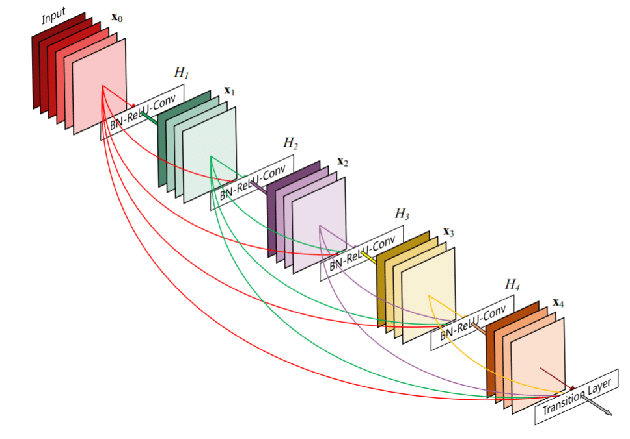

In [ ]:
def transferlearning(X_test, X_train_aumentado, Y_train, features, tam_img, aumentado, _batch_size, n_cat,problema, Y_test): #Agregar variable problema PENDIENTE

  if aumentado == True and problema!= "yoga":
    Y_train= pd.concat([Y_train,Y_train], axis=0).reset_index(drop=True)

  base_model  = tf.keras.applications.DenseNet201(input_shape=(tam_img,tam_img,3),
                                                include_top=False,
                                                weights='imagenet') # cargamos con pesos entrenados en ImageNet
  base_model.trainable = False
  model3 = keras.Model(inputs=base_model.inputs, outputs = base_model.layers[-1].output)
  #extraccion de caracteristicas
  features_aumentado = model3.predict(X_train_aumentado)
  features_test = model3.predict(X_test)


  if aumentado == True: #RECICLA LAS FEATURES DE LAS IMAGENES ORIGINALES
    features_aumentado= np.concatenate((features, features_aumentado),axis=0)

  print("dimensiones feautures Train",features_aumentado.shape)
  print("dimensiones feautures Test",features_test.shape)

  modelFF_2 = modelo_denso(features_aumentado, n_cat)

  modelFF_2.compile( loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])
  my_callbacks = [History(), EarlyStopping(patience=10, monitor="val_loss",restore_best_weights=True)]

  # Entrenar modelo
  history = modelFF_2.fit(
          x = features_aumentado,
          y = Y_train,
          validation_data=(features_test,Y_test),
          batch_size=_batch_size,
          epochs=100,
          verbose=0,
          callbacks= my_callbacks
      )

  epocas= len(history.history['accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']


  #Predicciones 

  y_pred = modelFF_2.predict(features_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred_clase=[] #Codificación

  for i in range(y_pred.shape[0]):
      respuesta= Y_train.columns[y_pred[i]]
      y_pred_clase.append(respuesta)


  
  return features_aumentado, epocas, acc, val_acc, loss, val_loss, y_pred_clase




# Clasificación de Felinos

## Datos

In [ ]:
img_folder_cat = path+'Felinos/train/cat' #0 - 49
img_folder_lion = path+'Felinos/train/lion' #100 - 149
img_folder_tiger = path+'Felinos/train/tiger' # 200 - 249
img_folder_leopard = path+'Felinos/train/leopard' #300 - 349



df = pd.DataFrame(columns=['image', 'class'])
df_test = pd.DataFrame(columns=['image', 'class'])

c=0
j=0

for i in range(0,400):
    if 0<=i<=49:
        df.loc[c] = [str(i)+'.jpg', 'cat']
        c+=1
        
    if 50<= i <= 99:
        df_test.loc[j] = [str(i)+'.jpg', 'cat']
        j+=1
        
    if 100<=i<=149:
        df.loc[c] = [str(i)+'.jpg', 'lion']
        c+=1
    
    if 150<= i <= 199:
        df_test.loc[j] = [str(i)+'.jpg', 'lion']
        j+=1
    
    if 200<=i<=249:
        df.loc[c] = [str(i)+'.jpg', 'tiger']
        c+=1
    
    if 250<= i <= 299:
        df_test.loc[j] = [str(i)+'.jpg', 'tiger']
        j+=1
    
    if 300<=i<=349:
        df.loc[c] = [str(i)+'.jpg', 'leopard']
        c+=1
        
    if 350<= i <= 399:
        df_test.loc[j] = [str(i)+'.jpg', 'leopard']
        j+=1

df

image    class
0      0.jpg      cat
1      1.jpg      cat
2      2.jpg      cat
3      3.jpg      cat
4      4.jpg      cat
..       ...      ...
195  345.jpg  leopard
196  346.jpg  leopard
197  347.jpg  leopard
198  348.jpg  leopard
199  349.jpg  leopard

[200 rows x 2 columns]

## Preprocesamiento Train

In [ ]:
def process_dataset(img_folder, dat, width=254, height=254):
    data = []
    ids = []
   
    for filename in os.listdir(img_folder):
        
        image_path = os.path.join(img_folder, filename)
        image = cv2.imread( image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # ahora trabajamos con imágenes RGB

        # hacemos un resize del tamaño de las imágenes antes de ingresarlo a nuestro modelo
        image = cv2.resize(image, (width, height)) # por ejemplo, 52 x 52 x 3 (3 canales => rojo, verde y azul)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 # escalar a [0, 1] 


        # obtener la clase correspondiente en los datos del csv usando la id de la imagen
        c = dat.loc[dat['image'] == filename]['class'].values[0]
                 
        data.append([c, image])

        ids.append(filename)
    
    return np.array(data), np.array(ids)


# img_data -> class, image
img_data_cat,  ids_cat = process_dataset(img_folder_cat, df)
img_data_lion,  ids_lion = process_dataset(img_folder_lion, df)
img_data_tiger,  ids_tiger = process_dataset(img_folder_tiger, df)
img_data_leopard,  ids_leopard = process_dataset(img_folder_leopard, df)

print(img_data_cat[0][1].shape)
print(img_data_lion[0][1].shape)
print(img_data_tiger[0][1].shape)
print(img_data_leopard[0][1].shape)

    
img_data = np.array(list(img_data_cat)+list(img_data_lion)+list(img_data_tiger)+list(img_data_leopard)) 

    
ids = np.array(list(ids_cat)+list(ids_lion)+list(ids_tiger)+list(ids_leopard))

(254, 254, 3)
(254, 254, 3)
(254, 254, 3)
(254, 254, 3)


## Preprocesamiento Test

In [ ]:
img_folder_cat_t = path+'Felinos/test/cat'
img_folder_lion_t = path+'Felinos/test/lion'
img_folder_tiger_t = path+'Felinos/test/tiger'
img_folder_leopard_t = path+'Felinos/test/leopard'

# img_data -> class, image
img_data_cat_t,  ids_cat_t = process_dataset(img_folder_cat_t, df_test)
img_data_lion_t,  ids_lion_t = process_dataset(img_folder_lion_t, df_test)
img_data_tiger_t,  ids_tiger_t = process_dataset(img_folder_tiger_t, df_test)
img_data_leopard_t,  ids_leopard_t = process_dataset(img_folder_leopard_t, df_test)

print(img_data_cat_t[0][1].shape)
print(img_data_lion_t[0][1].shape)
print(img_data_tiger_t[0][1].shape)
print(img_data_leopard_t[0][1].shape)

    
img_data_t = np.array(list(img_data_cat_t)+list(img_data_lion_t)+list(img_data_tiger_t)+list(img_data_leopard_t)) 

    
ids_t = np.array(list(ids_cat_t)+list(ids_lion_t)+list(ids_tiger_t)+list(ids_leopard_t))

(254, 254, 3)
(254, 254, 3)
(254, 254, 3)
(254, 254, 3)


Ejemplos

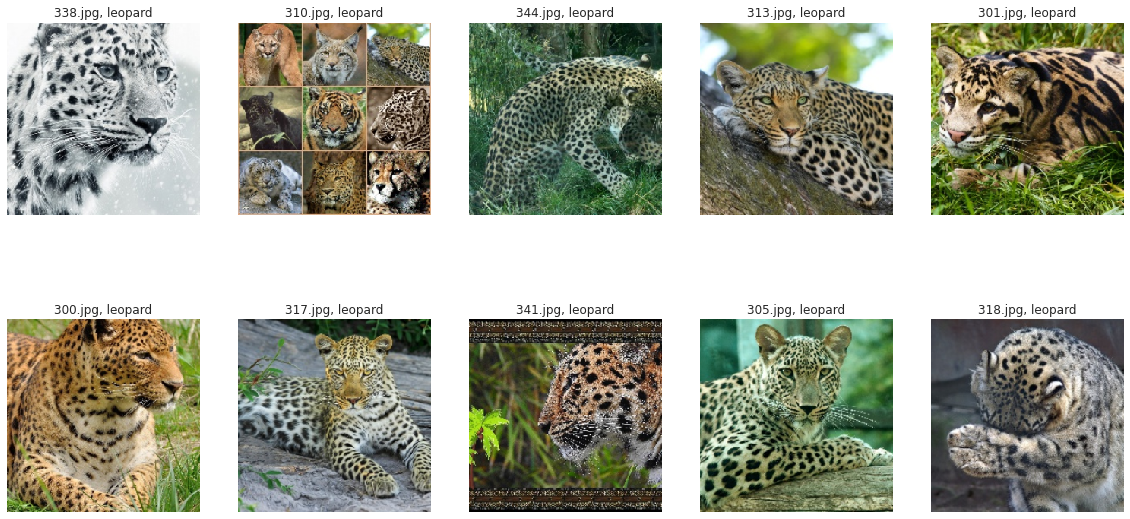

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(10):
    c=i+150
    img = Image.fromarray(np.uint8(img_data[c][1] * 255))
    
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(ids[c] + ', ' + img_data[c][0] )

    plt.imshow(img, interpolation='none')
    plt.axis("off")

Categorias Train

In [ ]:
n_classes = 4

X_train = np.array(img_data[:, 1].tolist())

# codificación one-hot para etiquetas (cat - lion - tiger - leopard)
Y_train =  pd.get_dummies(img_data[:, 0])

Y_train

cat  leopard  lion  tiger
0      1        0     0      0
1      1        0     0      0
2      1        0     0      0
3      1        0     0      0
4      1        0     0      0
..   ...      ...   ...    ...
195    0        1     0      0
196    0        1     0      0
197    0        1     0      0
198    0        1     0      0
199    0        1     0      0

[200 rows x 4 columns]

Categorias Test

In [ ]:
X_test = np.array(img_data_t[:, 1].tolist())

# codificación one-hot para etiquetas (cat - lion - tiger - leopard)
Y_test =  img_data_t[:, 0]

In [ ]:
print("X,y train Shapes:", X_train.shape, Y_train.shape)
print("X,y test Shapes:", X_test.shape, Y_test.shape)

X,y train Shapes: (200, 254, 254, 3) (200, 4)
X,y test Shapes: (200, 254, 254, 3) (200,)


## Sin Data Augmentation

74842112/74836368 [==============================] - 0s 0us/step
dimensiones feautures Train (200, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)


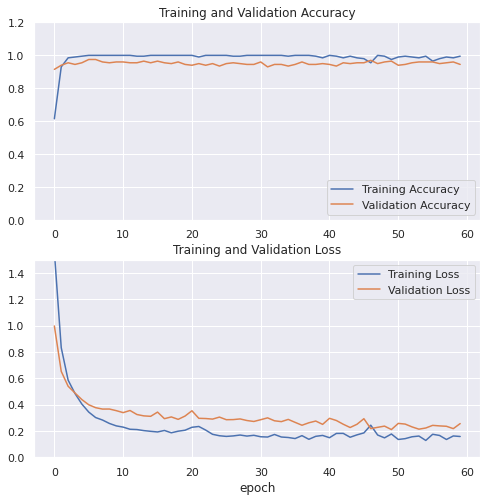

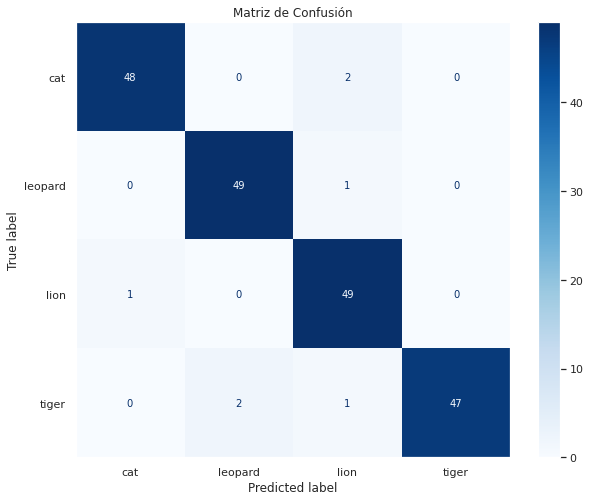

F1 Score:  0.9651306187570013


In [ ]:
features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_test, X_train, Y_train, 'a', 254, False, 16, 4,"felinos",pd.get_dummies(Y_test))

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_clase, labels=Y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(Y_test, y_pred_clase, average='macro'))

resultados = [(f1_score(Y_test, y_pred_clase, average='macro'), "Original")]

## Con Data Augmentation

Ejemplo

In [ ]:
ejemplo= X_train[88]
image = tf.expand_dims(ejemplo, 0)

(-0.5, 253.5, 253.5, -0.5)

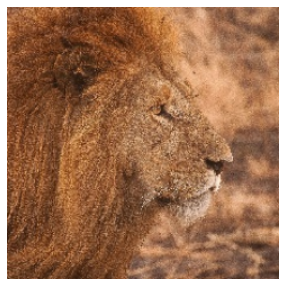

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image[0])
plt.axis("off")

### Rotaciones

In [ ]:
data_augmentation_rotacion = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

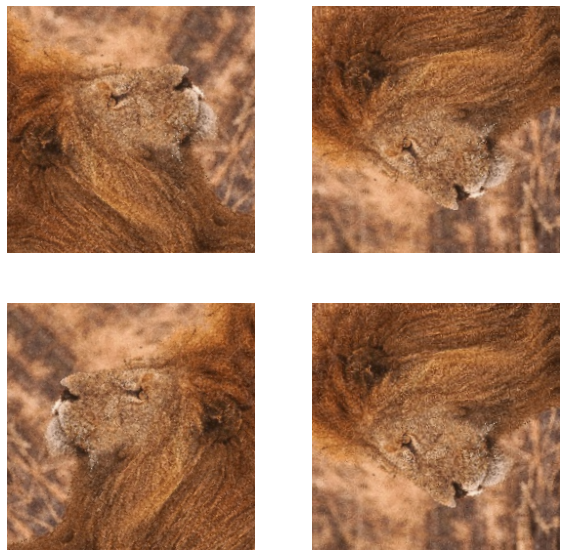

In [ ]:

plt.figure(figsize=(10, 10))
for i in range(4):
  augmented_image = data_augmentation_rotacion(image)
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
def rotaciones(X_train):

  for i in range(X_train.shape[0]):
    imagen= X_train[i]
    imagen=tf.expand_dims(imagen, 0)
    if i==0:
      X_train_aumentado= data_augmentation_rotacion(imagen)
    else:
      X_train_aumentado=np.concatenate((X_train_aumentado, data_augmentation_rotacion(imagen)),axis=0)


  return X_train_aumentado

dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)


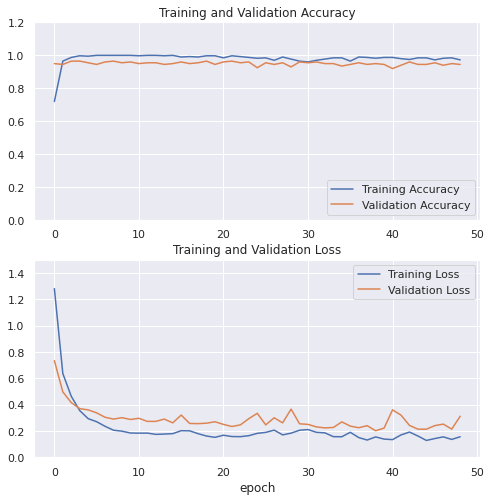

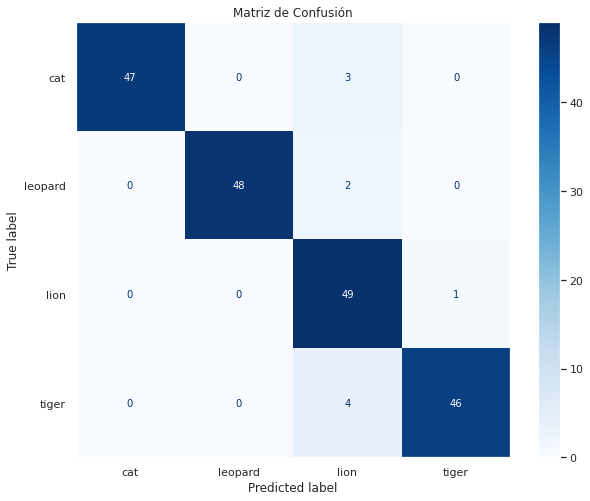

F1 Score:  0.9511312543344943


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase= transferlearning(X_test, rotaciones(X_train), Y_train, features, 254, True, 16, 4, "felinos",pd.get_dummies(Y_test))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_clase, labels=Y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ",f1_score(Y_test, y_pred_clase, average='macro'))

resultados.append((f1_score(Y_test, y_pred_clase, average='macro'), "Rotacion"))

### Ruido Gaussiano


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 253.5, 253.5, -0.5)

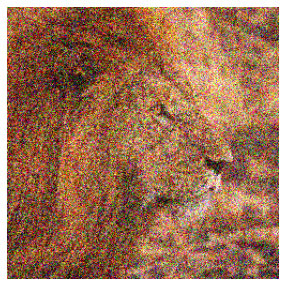

In [ ]:
sample = GaussianNoise(0.2) #desviación estandar
noisey = sample(image,training=True)
plt.figure(figsize=(5, 5))
plt.imshow(noisey[0])
plt.axis("off")

In [ ]:
def gaussiano(X_train):

  for i in range(X_train.shape[0]):
    imagen= X_train[i]
    imagen=tf.expand_dims(imagen, 0)

    if i==0:
        X_train_aumentado= sample(imagen,training=True)
    else:
      X_train_aumentado=np.concatenate((X_train_aumentado, sample(imagen,training=True)),axis=0)

  return X_train_aumentado

dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)


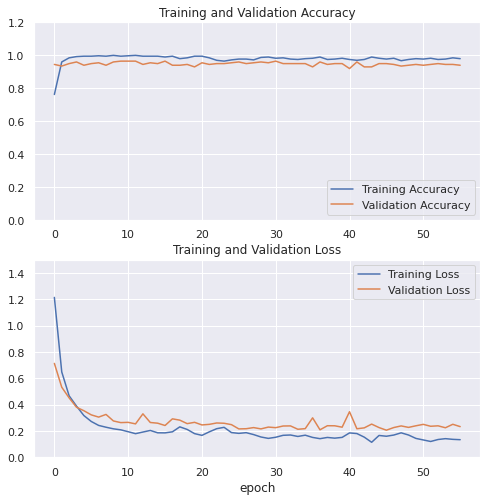

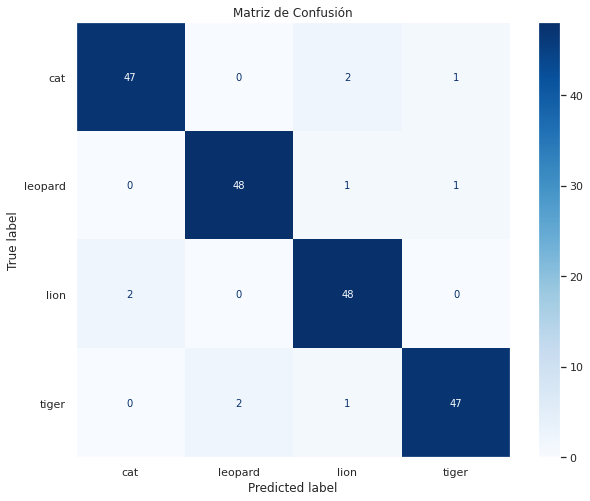

F1 Score:  0.9500415923945335


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase= transferlearning(X_test, gaussiano(X_train), Y_train, features, 254, True, 16, 4, "felinos",pd.get_dummies(Y_test))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_clase, labels=Y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ",f1_score(Y_test, y_pred_clase, average='macro'))

resultados.append((f1_score(Y_test, y_pred_clase, average='macro'), "Ruido"))

### Brillo

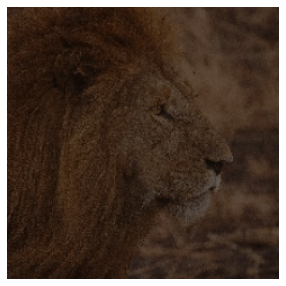

In [ ]:
sam = image
# create image data augmentation generator
imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.3,0.4]) #[1.5,1.8]
# image ploting
iterator = imageDataGenerator_obj.flow(sam, batch_size=1)
chunk = iterator.next()

sub_img = chunk[0].astype('uint8')

plt.figure(figsize=(5, 5))
plt.imshow(sub_img)
plt.axis("off")
plt.show()

In [ ]:
def brillo(X_train):

  for i in range(X_train.shape[0]):
    imagen= X_train[i]
    imagen=tf.expand_dims(imagen, 0)
    iterator = imageDataGenerator_obj.flow(imagen, batch_size=1)
    chunk = iterator.next()
    sub_img = chunk[0].astype('uint8')
    sub_img=tf.expand_dims(sub_img, 0)
    if i==0:
        X_train_aumentado= sub_img
    else:
      X_train_aumentado=np.concatenate((X_train_aumentado, sub_img),axis=0)

  return X_train_aumentado

dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)


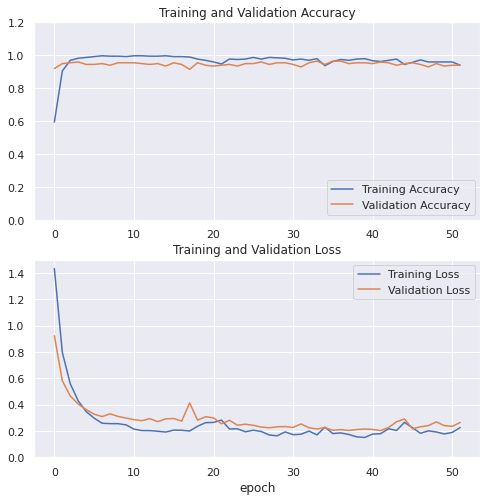

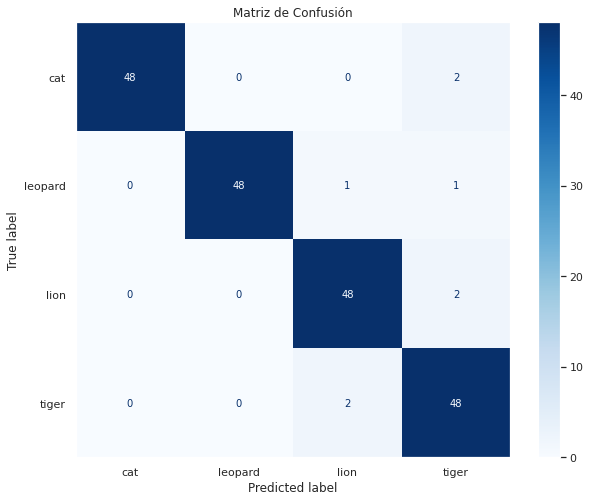

F1 Score:  0.9604293894814486


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase= transferlearning(X_test, brillo(X_train), Y_train, features, 254, True, 16, 4, "felinos",pd.get_dummies(Y_test))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_clase, labels=Y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ",f1_score(Y_test, y_pred_clase, average='macro'))

resultados.append((f1_score(Y_test, y_pred_clase, average='macro'), "Brillo"))

### Cropping( zoom)



(-0.5, 253.5, 253.5, -0.5)

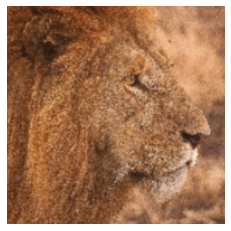

In [ ]:
y = tf.keras.layers.Cropping2D(cropping=((30, 30), (30, 30)))(image) #(,)-vertical (,)- horizontal 
#y = cv2.cvtColor(np.array(y), cv2.COLOR_BGR2RGB) 
y = cv2.resize(np.array(y)[0], (254, 254))
y.shape
plt.imshow(y)
plt.axis("off")

In [ ]:
def zoom(X_train):

  for i in range(X_train.shape[0]):
    imagen= X_train[i]
    y = tf.keras.layers.Cropping2D(cropping=((30, 30), (30, 30)))(image) #(,)-vertical (,)- horizontal  
    y = cv2.resize(np.array(y)[0], (254, 254))
    y=tf.expand_dims(y, 0)
    if i==0:
        X_train_aumentado= y
    else:
      X_train_aumentado=np.concatenate((X_train_aumentado,y),axis=0)

  return X_train_aumentado


dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)


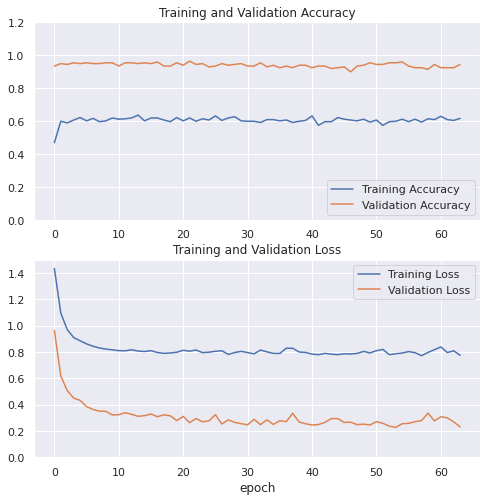

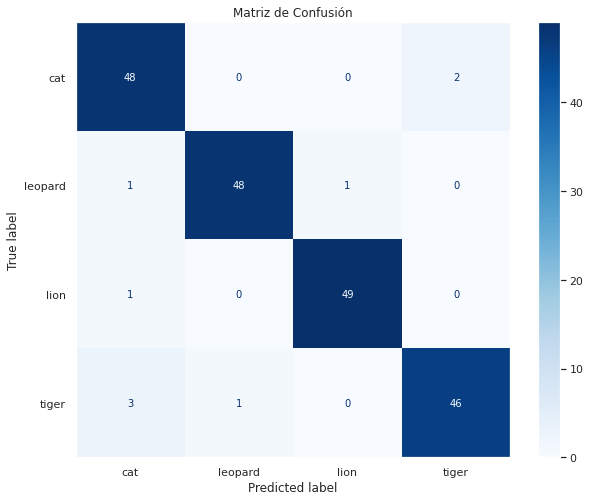

F1 Score:  0.955127828713127


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase= transferlearning(X_test,zoom(X_train), Y_train, features, 254, True, 16, 4, "felinos",pd.get_dummies(Y_test))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_clase, labels=Y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ",f1_score(Y_test, y_pred_clase, average='macro'))

resultados.append((f1_score(Y_test, y_pred_clase, average='macro'), "Zoom"))

In [ ]:
resultados

[(0.9651306187570013, 'Original'),
 (0.9511312543344943, 'Rotacion'),
 (0.9500415923945335, 'Ruido'),
 (0.9604293894814486, 'Brillo'),
 (0.955127828713127, 'Zoom')]

## Comparacion


In [ ]:
sin_aumentation=[]
rotacioness=[]
Gaussianos=[]
Brillos=[]
Zoom=[]
X_train_rot=rotaciones(X_train)
X_train_gauss=gaussiano(X_train)
X_train_brillo=brillo(X_train)
X_train_zoom=zoom(X_train)
for i in range(10):
  #Original
  features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_test, X_train, Y_train, features, 254, False, 16 , 4,  "felinos", pd.get_dummies(Y_test) )
  sin_aumentation.append(f1_score(Y_test, y_pred_clase, average='macro'))

  #Rotaciones
  features_1, epocas1, acc1, val_acc1, loss1, val_loss1, y_pred_clase1 = transferlearning(X_test, X_train_rot, Y_train, features, 254, True, 16 , 4,  "felinos", pd.get_dummies(Y_test) )
  rotacioness.append(f1_score(Y_test, y_pred_clase1, average='macro'))

  #Ruido Gaussiano
  features_2, epocas2, acc2, val_acc2, loss2, val_loss2, y_pred_clase2 = transferlearning(X_test, X_train_gauss, Y_train, features, 254, True, 16 , 4,  "felinos", pd.get_dummies(Y_test) )
  Gaussianos.append(f1_score(Y_test, y_pred_clase2, average='macro'))

  #Brillo
  features_3, epocas3, acc3, val_acc3, loss3, val_loss3, y_pred_clase3 = transferlearning(X_test, X_train_brillo, Y_train, features, 254, True, 16 , 4, "felinos", pd.get_dummies(Y_test) )
  Brillos.append(f1_score(Y_test, y_pred_clase3, average='macro'))

  #Zoom
  features_4, epocas4, acc4, val_acc4, loss4, val_loss4, y_pred_clase4= transferlearning(X_test, X_train_zoom, Y_train, features, 254,True, 16 , 4,  "felinos",pd.get_dummies(Y_test) )
  Zoom.append(f1_score(Y_test, y_pred_clase4, average='macro'))


dimensiones feautures Train (200, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (200, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (400, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)
dimensiones feautures Train (200, 8, 8, 1920)
dimensiones feautures Test (200, 8, 8, 1920)

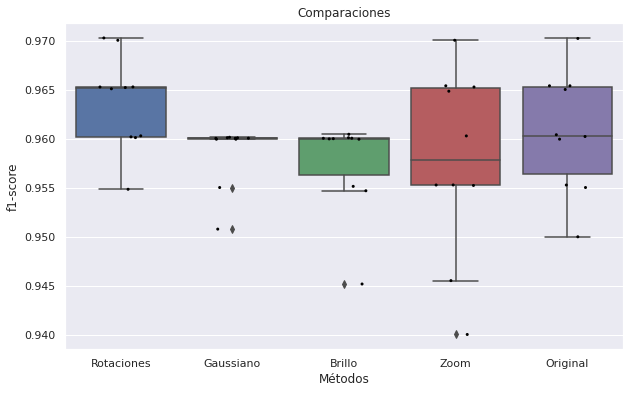

In [ ]:
#Plot

a = pd.DataFrame({ 'Métodos' : np.repeat('Rotaciones',10), 'f1-score': rotacioness })
b = pd.DataFrame({ 'Métodos' : np.repeat('Gaussiano',10), 'f1-score': Gaussianos })
c = pd.DataFrame({ 'Métodos' : np.repeat('Brillo',10), 'f1-score': Brillos })
d = pd.DataFrame({ 'Métodos' : np.repeat('Zoom',10), 'f1-score': Zoom })
e = pd.DataFrame({ 'Métodos' : np.repeat('Original',10), 'f1-score':sin_aumentation })
df=a.append(b).append(c).append(d).append(e)

plt.figure(figsize=(10,6))
ax = sns.boxplot(x='Métodos', y='f1-score', data=df)
# add stripplot
ax = sns.stripplot(x='Métodos', y='f1-score', data=df, color="black", jitter=0.2, size=3)

# add title
plt.title('Comparaciones', loc="center")

# show the graph
plt.show()

Podemos observar en el gráfico, que para el problema de clasificación de felinos, data augmentation con rotaciones resulta ser el método más efectivo dentro de un pequeño margen, pues su rango intercuartílico se encuentra por sobre la mediana de los otros métodos. Por otro lado, tenemos el caso de ruido gaussiano, método que segun los resultados obtenidos ha disminuido considerablemente la variabilidad del modelo, haciendo que se uno más robusto, sin embargo, no necesariamente mejor en la métrica de interés (F1-score). Finalmente tenemos el método zoom, el cual ha agregado variabilidad al modelo, esto se atribuye principalmente a que el método consiste en recortar los bordes de las imagenes, y en este proceso es posible que se eliminen patrones locales importantes para la clasificación. 

Notamos que en este caso, no aprecian **mejoras notables** en los resultados del F1-score al momento de aplicar data augmentation. Es por esto que buscamos un problema que presente mayor dificultad en la clasificación, con el fin de poder evidenciar cambios significativos en los resultados obtenidos.

# YOGA 

## Datos

In [ ]:
train= open(path+'Yoga-Dataset/yoga_train.txt','r')
train= train.read()

In [ ]:
df= pd.DataFrame(columns=["imagen","superclase","subclase","combinacion"])
c=0
for tupla in train.split("\n")[:-1]:
    im=tupla.split(",")[0]
    superc,subc=tupla.split(",")[1].split()
    df.loc[c]=[im,int(superc),int(subc), superc+"."+subc ]
    c+=1

In [ ]:
df

imagen superclase subclase combinacion
0        0.jpg          1       14        1.14
1        1.jpg          1       14        1.14
2        2.jpg          1       14        1.14
3        4.jpg          1       14        1.14
4        6.jpg          1       14        1.14
...        ...        ...      ...         ...
1245  1323.jpg          4       19        4.19
1246  1324.jpg          4       19        4.19
1247  1325.jpg          4       19        4.19
1248  1326.jpg          4       19        4.19
1249  1327.jpg          4       19        4.19

[1250 rows x 4 columns]

In [ ]:
def cargar_imagenes(df):
        #ojo con la forma que requiere el df
    tamaño= 224
    errores=[]
    inputImages = []
    for i in range(df.shape[0]):
        nombre= df.imagen[i]
        try:
            image = mpimg.imread(path+"Yoga-Dataset/Images/"+ nombre)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # ahora trabajamos con imágenes RGB
            image = cv2.resize(image, (tamaño, tamaño)) #fijar tamaño
            image=np.array(image)
            image = image.astype('float32')
            image = image/255 # escalar a [0, 1] 
            ###################
            inputImages.append(image)

        except:
            print(i)
            errores.append(i)
            pass

        # filename not an image file
   
    return inputImages, errores 

In [ ]:
Imagenes,indicesconerror=cargar_imagenes(df)

In [ ]:
y =  pd.get_dummies(df['combinacion'])
X = np.array(Imagenes)  #Imagenes_aumentadas #

# Split de los ejemplos de entrenamiento
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)


print("X,y Shapes:", X.shape, y.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)

y_val=y_val.idxmax(axis=1)
df_2 = df.iloc[y_train.index].reset_index()

X,y Shapes: (1250, 224, 224, 3) (1250, 22)
X,y Train Shapes: (1000, 224, 224, 3) (1000, 22)
X,y Val Shapes: (250, 224, 224, 3) (250, 22)


Problema desbalanceado

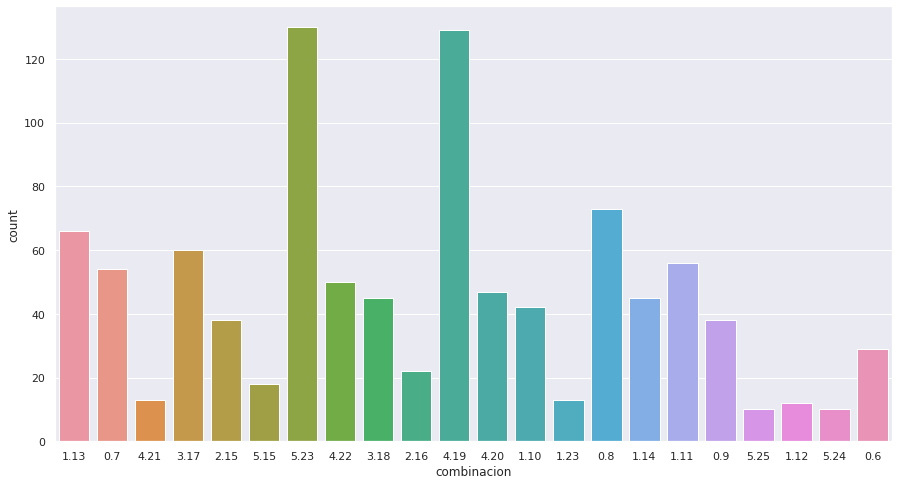

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(x="combinacion", data=df_2)

## Sin Data Augmentation

dimensiones feautures Train (1000, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


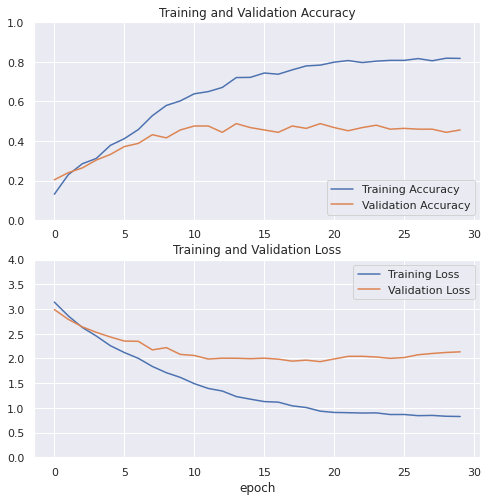

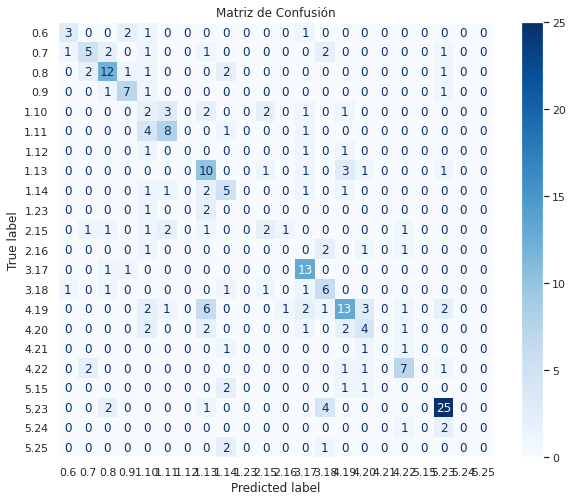

F1 Score:  0.3299421886796979


In [ ]:
features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train, y_train, 'a', 224, False, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

## Con Data Augmentation Total

In [ ]:
## Cantidad de imagenes que le faltan a la clase

max = df_2['combinacion'].value_counts().max()

dic = {}

for i in range(len(df_2['combinacion'].value_counts().index)):

  division = max//df_2['combinacion'].value_counts()[i]
  resto = int(max%df_2['combinacion'].value_counts()[i])
  if division-1 <0:
    division=1
  
  dic[df_2['combinacion'].value_counts().index[i]] = (int(division-1), resto )

In [ ]:
clases = df['combinacion'].unique()

y_train_aumentado = list(y_train.idxmax(axis=1))

for clase in clases: 
  n_rot, rot_solas = dic[clase]
  im=len(df_2[df_2['combinacion']==clase].index)
  for j in range(rot_solas):
      y_train_aumentado=y_train_aumentado+[clase]
  for i in range(n_rot*im):
     y_train_aumentado=y_train_aumentado+[clase]

y_train_aumentado =  pd.get_dummies(y_train_aumentado)

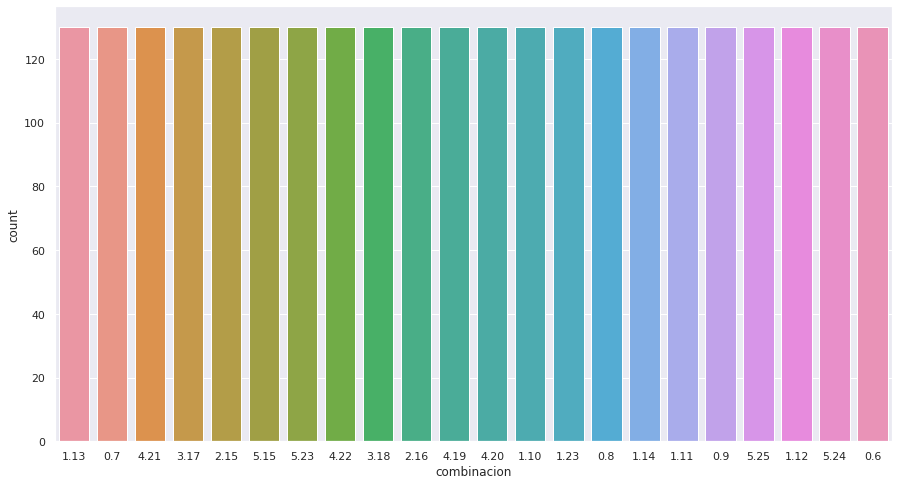

In [ ]:
data_balanceado= pd.DataFrame(columns=["indice", "combinacion"])
data_balanceado["indice"]=range(len(y_train_aumentado.idxmax(axis=1)))
data_balanceado["combinacion"] =y_train_aumentado.idxmax(axis=1)

#grafica
plt.figure(figsize=(15,8))
sns.countplot(x="combinacion" ,data= data_balanceado)

Notamos que ahora el problema es balanceado

### Rotaciones


In [ ]:
def n_rotaciones(imagen, n_rot):
  
  imagen=tf.expand_dims(imagen, 0)
  n=0.15
  if n_rot == 1:
    n = 0.1

  for i in range(n_rot):
    data_augmentation_rotacion = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(n),
    ])
    if i==0:
      n+=0.05
      arr=np.array(data_augmentation_rotacion(imagen))
    else:
      n+=0.05
      arr=np.concatenate((arr, np.array(data_augmentation_rotacion(imagen))),axis=0)

  return arr

In [ ]:
def rotaciones(X_train):
  c=0
  for clase in clases:
    n_rot, rot_solas = dic[clase]
    im = df_2[df_2['combinacion']==clase].index
    im_solas=im[:rot_solas]
    #Rotaciones Solas
    for j in im_solas:
      imagen = X_train[j]
      if c == 0:
        X_train_aumentado = n_rotaciones(imagen,1)
        c=1
      else:
        X_train_aumentado=np.concatenate((X_train_aumentado, n_rotaciones(imagen, 1)),axis=0)
    for i in im:
      if n_rot != 0:
        imagen= X_train[i]
        X_train_aumentado=np.concatenate((X_train_aumentado, n_rotaciones(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train2=rotaciones(X_train)

dimensiones feautures Train (2860, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


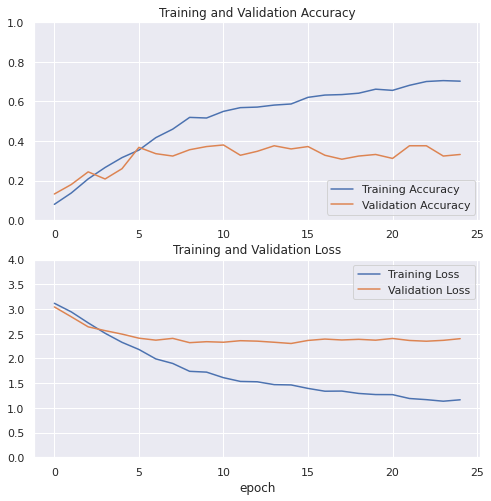

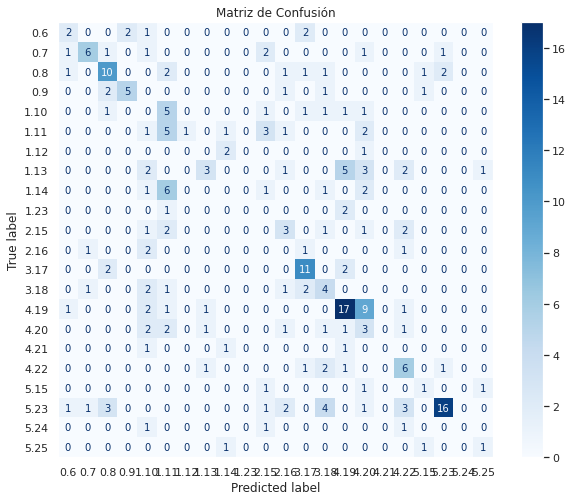

F1 Score:  0.2614269631497327


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train2, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Ruido Gussiano

In [ ]:
def n_gaussiano(imagen, n_rot):
  
  imagen=tf.expand_dims(imagen, 0)
  n=0.2
  if n_rot == 1:
    n = 0.1

  for i in range(n_rot):
    n_v= 0.1+n/2
    sample = GaussianNoise(n_v) #desviación estandar
    noisey = sample(imagen,training=True)
    if i==0:
      n+=0.1
      arr=np.array(sample(imagen,training=True))
    else:
      n+=0.1
      arr=np.concatenate((arr, sample(imagen,training=True)),axis=0)

  return arr

In [ ]:
def gaussiano(X_train):
  c=0
  for clase in clases:
    n_rot, rot_solas = dic[clase]
    im = df_2[df_2['combinacion']==clase].index
    im_solas=im[:rot_solas]
    #Rotaciones Solas
    for j in im_solas:
      imagen = X_train[j]
      if c == 0:
        X_train_aumentado = n_gaussiano(imagen,1)
        c=1
      else:
        X_train_aumentado=np.concatenate((X_train_aumentado, n_gaussiano(imagen,1)),axis=0)
    for i in im:
      if n_rot != 0:
        imagen= X_train[i]
        X_train_aumentado=np.concatenate((X_train_aumentado, n_gaussiano(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train2=gaussiano(X_train)

dimensiones feautures Train (2860, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


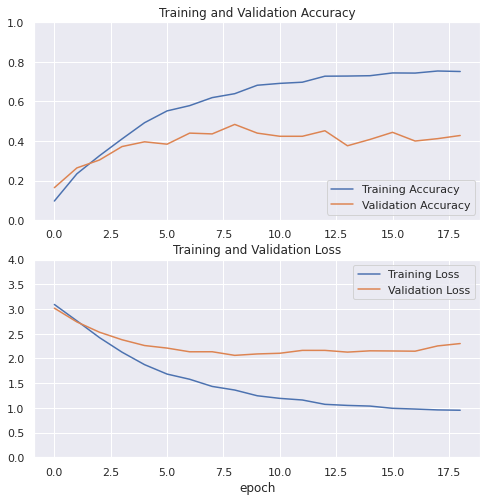

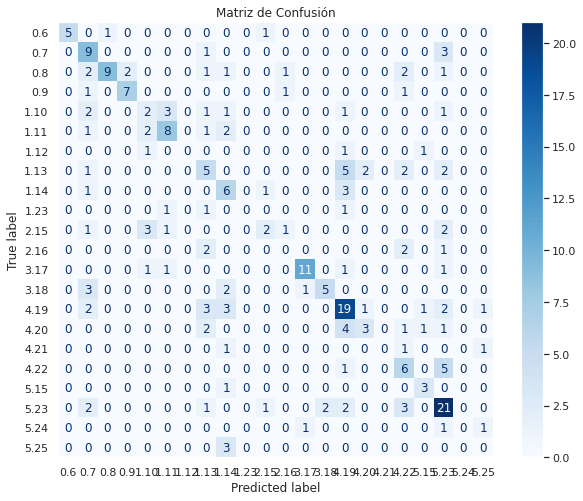

F1 Score:  0.37128447206872883


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train2, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Brillo

In [ ]:
def n_brillo(imagen, n_rot):
  
  imagen=tf.expand_dims(imagen, 0)
  n=0.2
  if n_rot == 1:
    n = 0.1

  for i in range(n_rot):
    imageDataGenerator_obj = ImageDataGenerator(brightness_range=[n,n]) #[1.5,1.8]
    iterator = imageDataGenerator_obj.flow(imagen, batch_size=1)
    chunk = iterator.next()
    sub_img = chunk[0].astype('uint8')
    sub_img=tf.expand_dims(sub_img, 0)
    if i==0:
      n+=0.1
      arr= sub_img
    else:
      n+=0.1
      arr=np.concatenate((arr, sub_img),axis=0)

  return arr

In [ ]:
def brillo(X_train):
  c=0
  for clase in clases:
    n_rot, rot_solas = dic[clase]
    im = df_2[df_2['combinacion']==clase].index
    im_solas=im[:rot_solas]
    #Rotaciones Solas
    for j in im_solas:
      imagen = X_train[j]
      if c == 0:
        X_train_aumentado = n_brillo(imagen,1)
        c=1
      else:
        X_train_aumentado=np.concatenate((X_train_aumentado, n_brillo(imagen,1)),axis=0)
    for i in im:
      if n_rot != 0:
        imagen= X_train[i]
        X_train_aumentado=np.concatenate((X_train_aumentado, n_brillo(imagen, n_rot)),axis=0)

  return X_train_aumentado

dimensiones feautures Train (2860, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


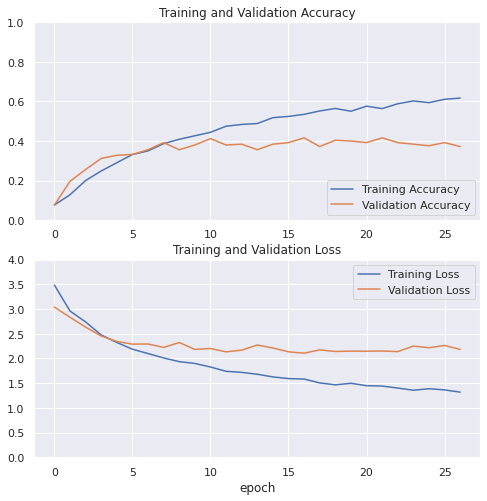

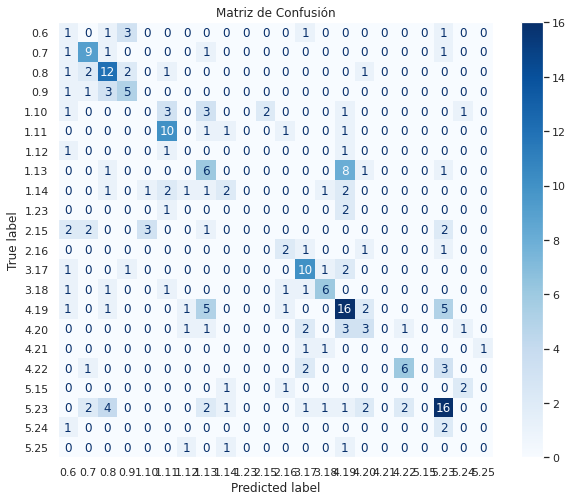

F1 Score:  0.2822114230642235


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, brillo(X_train), y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Cropping(zoom)

In [ ]:
def n_zoom(imagen, n_rot):
  
  imagen=tf.expand_dims(imagen, 0)
  n=2
  if n_rot == 1:
    n = 1

  for i in range(n_rot):
    n_v=29+n
    y = tf.keras.layers.Cropping2D(cropping=((n_v, n_v), (n_v, n_v)))(imagen) #(,)-vertical (,)- horizontal  
    y = cv2.resize(np.array(y)[0], (224, 224))
    sub_img=tf.expand_dims(y, 0)

    if i==0:
      n+=1
      arr=np.array(sub_img)
    else:
      n+=1
      arr=np.concatenate((arr, sub_img),axis=0)

  return arr


In [ ]:
def zoom(X_train):
  c=0
  for clase in clases:
    n_rot, rot_solas = dic[clase]
    im = df_2[df_2['combinacion']==clase].index
    im_solas=im[:rot_solas]
    #Rotaciones Solas
    for j in im_solas:
      imagen = X_train[j]
      if c == 0:
        X_train_aumentado = n_zoom(imagen,1)
        c=1
      else:
        X_train_aumentado=np.concatenate((X_train_aumentado, n_zoom(imagen,1)),axis=0)
    for i in im:
      if n_rot != 0:
        imagen= X_train[i]
        X_train_aumentado=np.concatenate((X_train_aumentado, n_zoom(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train2=zoom(X_train)

dimensiones feautures Train (2860, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


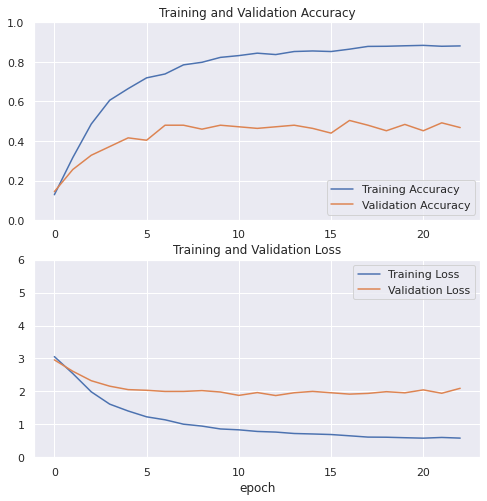

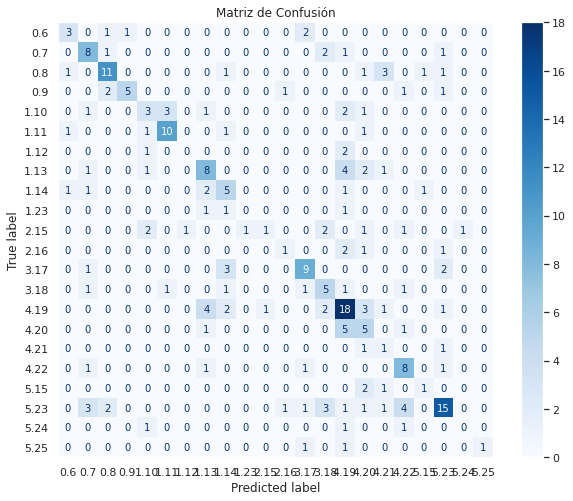

F1 Score:  0.3816649854735101


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train2, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### SVD 

Toda matriz tiene una aproximación de rango bajo según sus valores singulares, aplicamos esto a cada canal RGB

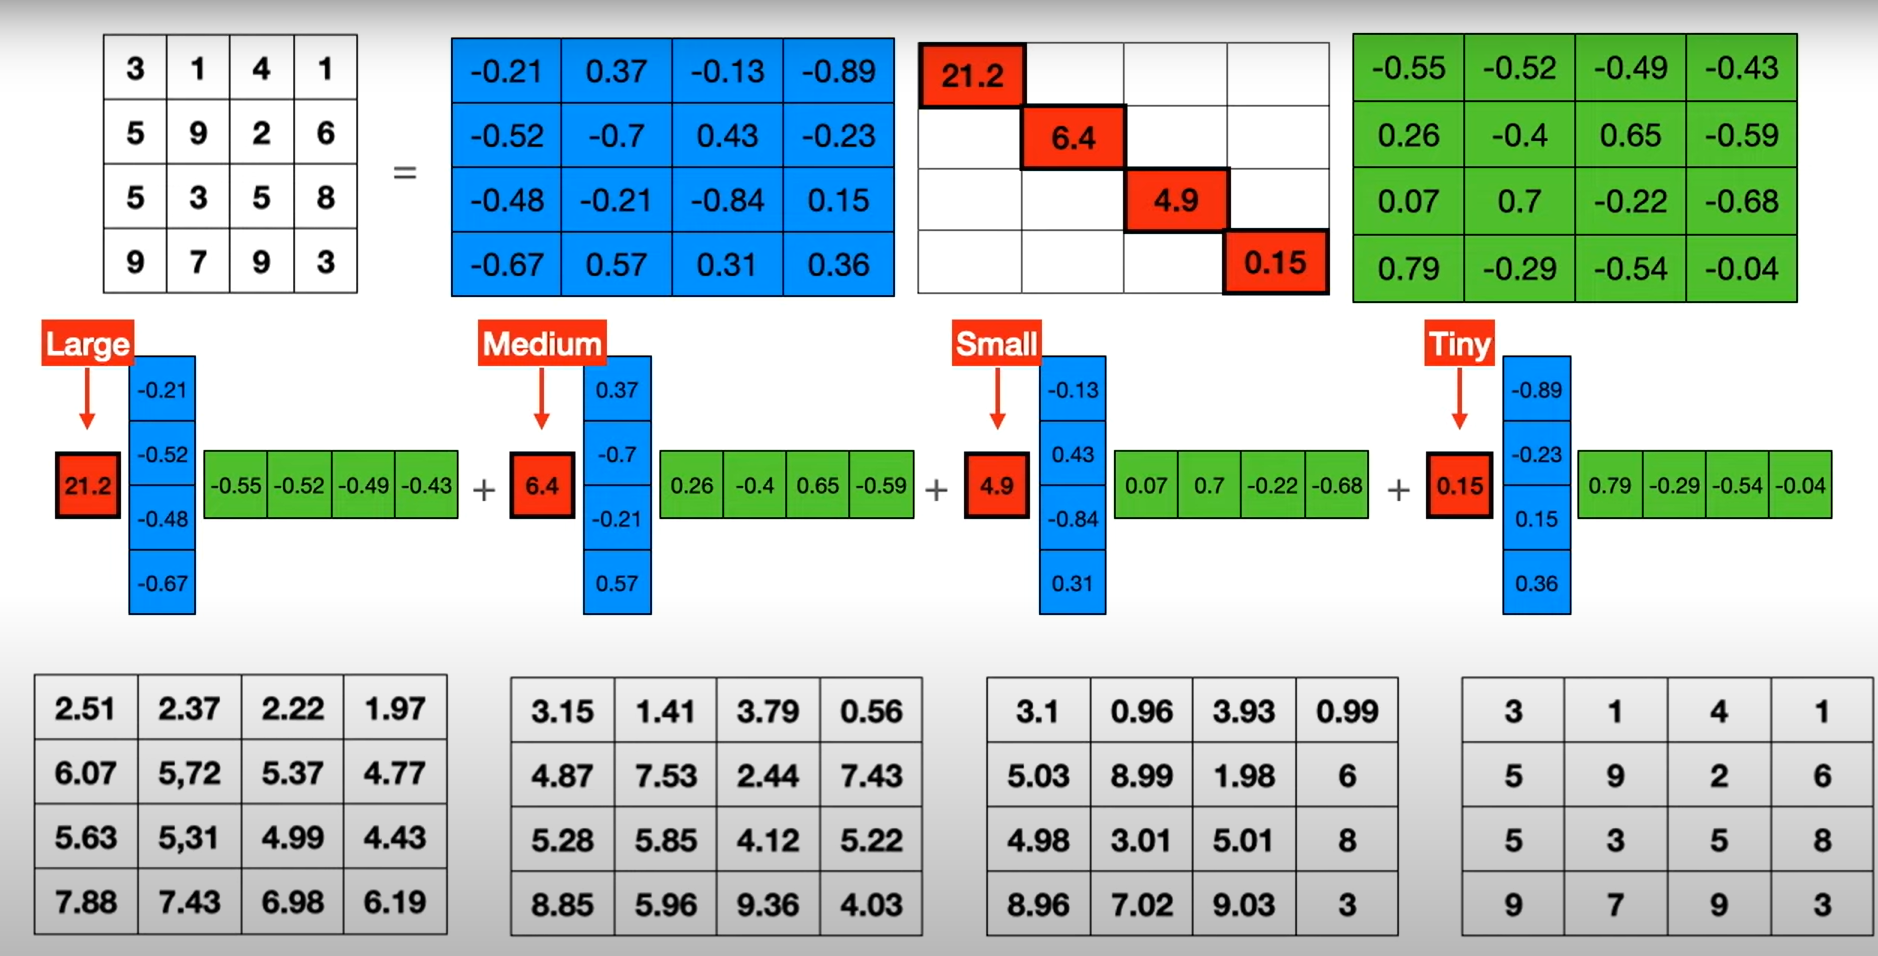

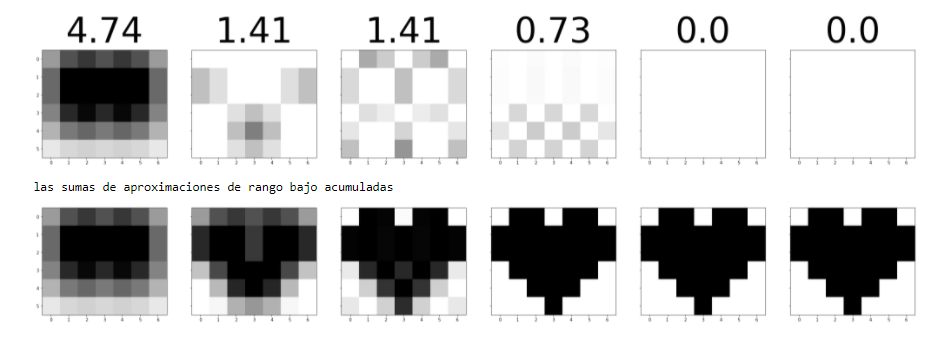

In [ ]:
def aprox_svd(imagen_matrix,n_aprox):
  svd_canales=[]
  svd_aprox_rango_bajo_acumulada=[]
  aproximaciones=n_aprox
  n=224
  for i in range(3):
    U, S, V = svd(imagen_matrix[:,:,i])
    svd_canales.append((U,S,V))
    combined_imgs = []
    imgs = []
    for i in range(aproximaciones):
        imgs.append(S[i]*np.outer(U[:,i],V[i])) #aprox de rango 1
        img = sum(imgs[:i+1]) #sumamos acumulando
        combined_imgs.append(img) #agregamos las suma sucesivas      
    svd_aprox_rango_bajo_acumulada.append(combined_imgs)  

  i=aproximaciones-1
  return np.dstack( (svd_aprox_rango_bajo_acumulada[0][i],  svd_aprox_rango_bajo_acumulada[1][i], svd_aprox_rango_bajo_acumulada[2][i]) )

In [ ]:
def n_svd(imagen, n_rot):
  
  imagen=tf.expand_dims(imagen, 0)
  n=25
  if n_rot == 1:
    n = 20

  for i in range(n_rot):
    sub_img = aprox_svd(imagen[0],n)
    sub_img=tf.expand_dims(sub_img, 0)
    
    if i==0:
      n-=1
      arr=np.array(sub_img)
    else:
      n-=1
      arr=np.concatenate((arr, sub_img),axis=0)

  return arr

In [ ]:
def svd_(X_train):
  c=0
  for clase in clases:
    n_rot, rot_solas = dic[clase]
    im = df_2[df_2['combinacion']==clase].index
    im_solas=im[:rot_solas]
    #Rotaciones Solas
    for j in im_solas:
      imagen = X_train[j]
      if c == 0:
        X_train_aumentado = n_svd(imagen,1)
        c=1
      else:
        X_train_aumentado=np.concatenate((X_train_aumentado, n_svd(imagen,1)),axis=0)
    for i in im:
      if n_rot != 0:
        imagen= X_train[i]
        X_train_aumentado=np.concatenate((X_train_aumentado, n_svd(imagen, n_rot)),axis=0)

  return X_train_aumentado

dimensiones feautures Train (1828, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


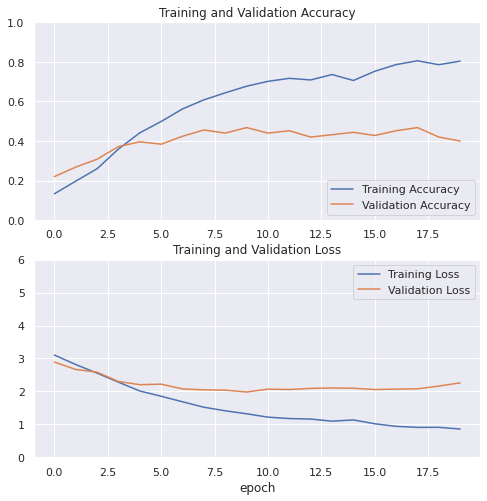

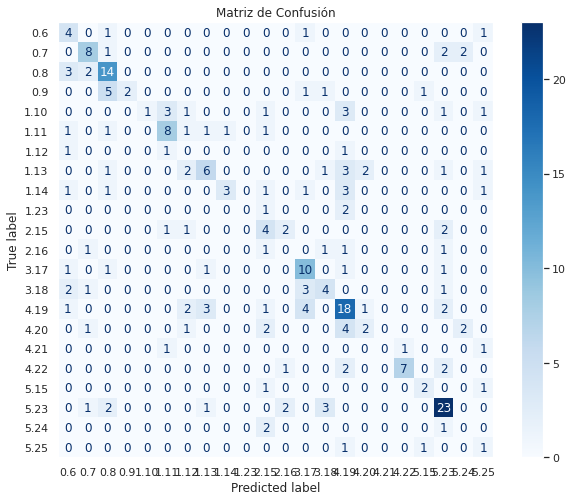

F1 Score:  0.34312937685506995


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, svd_(X_train), y_train, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

## Comparacion


No es posible ejecutar la celda por problemas de memoria RAM disponible.

In [ ]:
sin_aumentation=[]
rotacioness=[]
Gaussianos=[]
Brillos=[]
Zoom=[]
X_train_rot=rotaciones(X_train)
X_train_gauss=gaussiano(X_train)
X_train_brillo=brillo(X_train)
X_train_zoom=zoom(X_train)

for i in range(10):
  #Original
  features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train, y_train, 'a', 224, False, 32 , 22, "yoga", pd.get_dummies(y_val))
  sin_aumentation.append(f1_score(y_val, y_pred_clase, average='macro'))

  #Rotaciones
  features_1, epocas1, acc1, val_acc1, loss1, val_loss1, y_pred_clase1 = transferlearning(X_val, X_train_rot, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  rotacioness.append(f1_score(y_val, y_pred_clase1, average='macro'))

  #Ruido Gaussiano
  features_2, epocas2, acc2, val_acc2, loss2, val_loss2, y_pred_clase2 = transferlearning(X_val, X_train_gauss, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  Gaussianos.append(f1_score(y_val, y_pred_clase2, average='macro'))

  #Brillo
  features_3, epocas3, acc3, val_acc3, loss3, val_loss3, y_pred_clase3 = transferlearning(X_val, X_train_brillo, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  Brillos.append(f1_score(y_val, y_pred_clase3, average='macro'))

  #Zoom
  features_4, epocas4, acc4, val_acc4, loss4, val_loss4, y_pred_clase4= transferlearning(X_val, X_train_zoom, y_train_aumentado, features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  Zoom.append(f1_score(y_val, y_pred_clase4, average='macro'))


dimensiones feautures Train (1000, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (2860, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


In [ ]:
#Plot

a = pd.DataFrame({ 'Métodos' : np.repeat('Rotaciones',10), 'f1-score': rotacioness })
b = pd.DataFrame({ 'Métodos' : np.repeat('Gaussiano',10), 'f1-score': Gaussianos })
c = pd.DataFrame({ 'Métodos' : np.repeat('Brillo',10), 'f1-score': Brillos })
d = pd.DataFrame({ 'Métodos' : np.repeat('Zoom',10), 'f1-score': Zoom })
e = pd.DataFrame({ 'Métodos' : np.repeat('Original',10), 'f1-score':sin_aumentation })
df=a.append(b).append(c).append(d).append(e)

plt.figure(figsize=(10,6))
ax = sns.boxplot(x='Métodos', y='f1-score', data=df)
# add stripplot
ax = sns.stripplot(x='Métodos', y='f1-score', data=df, color="black", jitter=0.2, size=3)

# add title
plt.title('Comparaciones', loc="center")

# show the graph
plt.show()

Resultados

> Original: 0.3299

> Rotaciones: 0.2614

> Ruido Gaussiano: 0.3712

> Brillo: 0.2822

> Zoom: 0.3216

> SVD: 0.3431

Tenemos que debido a la naturaleza del problema, hay métodos de data augmentation que pueden perjudicar los resultados de la métrica de interés, como es el caso de Rotaciones. Naturalmente, el problema es sensible a las rotaciones, pues una rotación muy agresiva puede confundir al modelo en categorías donde una persona está de pie, con una categoría donde la persona está de cabeza. Finalmente, el método propuesto (SVD), no presenta resultados que indiquen una mejora notable en el F1-score.

Como el entrenamiento de la red utilizada tiene un elevado costo computacional, es imposible validar los resultados para diferentes instancias de forma similar a la del apartado de Felinos. Por lo que se propone hacer un balance de clases de manera parcial.

## Con Data Augmentation Parcial

In [ ]:
y_train_list = list(df_2['combinacion'])

Ejemplo de balanceo parcial de clases

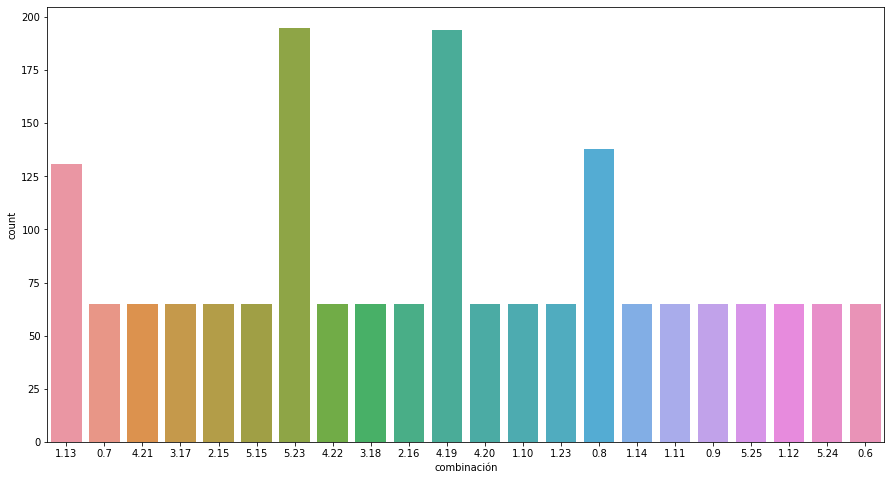

### Rotaciones


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])

In [ ]:
def rotaciones_p(X,y):
  c=0
  for clases in df_2.combinacion.unique():
    idx_post=df_2[df['combinacion']==clases].index
    obs_post=len(idx_post)

    if 20<= obs_post < 30: #1 vez

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        augmented_image = data_augmentation(image)
        if c==0:
            c=1
            X_train_aumentado= np.array(augmented_image)
            y=y+[clases]
        else: 
            X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image),axis=0)
            y=y+[clases]
        

    if obs_post < 20: #2 veces

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        if c==0:
          c=1
          augmented_image0 = data_augmentation(image)
          X_train_aumentado= np.array(augmented_image0)
          augmented_image1 = data_augmentation(augmented_image0)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]
        else: 
          augmented_image0 = data_augmentation(image)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image0),axis=0)
          augmented_image1 = data_augmentation(augmented_image0)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]

  return X_train_aumentado, y

dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


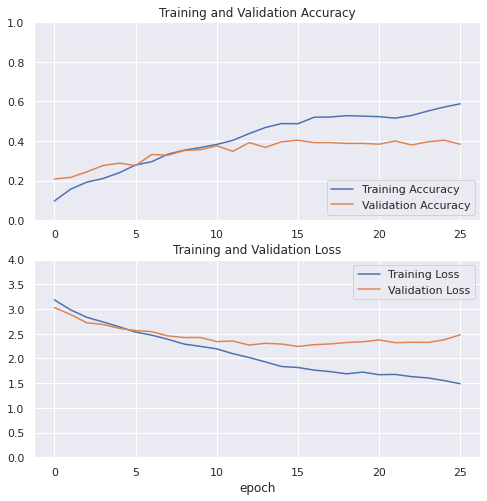

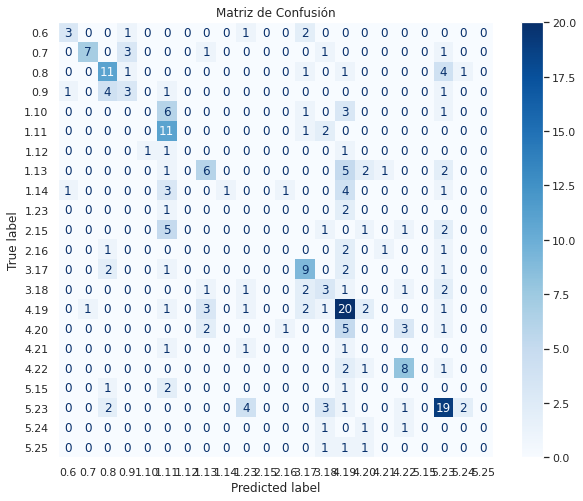

F1 Score:  0.249186125322489


In [ ]:
X_train_aumentado, y_aumentado =rotaciones_p(X_train,y_train_list)
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train_aumentado, pd.get_dummies(y_aumentado), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Ruido Gussiano

In [ ]:
sample = GaussianNoise(0.2) #desviación estandar
sample_1 =  GaussianNoise(0.3)

In [ ]:
def gaussiano_p(X,y):
  c=0
  for clases in df_2.combinacion.unique():
    idx_post=df_2[df['combinacion']==clases].index
    obs_post=len(idx_post)

    if 20<= obs_post < 30: #1 vez

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        augmented_image = sample(image,training=True)
        if c==0:
            c=1
            X_train_aumentado= np.array(augmented_image)
            y=y+[clases]
        else: 
            X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image),axis=0)
            y=y+[clases]
        

    if obs_post < 20: #2 veces

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        if c==0:
          c=1
          augmented_image0 =sample(image,training=True)
          X_train_aumentado= np.array(augmented_image0)
          augmented_image1 = sample_1(image,training=True)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]
        else: 
          augmented_image0 = sample(image,training=True)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image0),axis=0)
          augmented_image1 = sample_1(image,training=True)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]

  return X_train_aumentado, y

dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


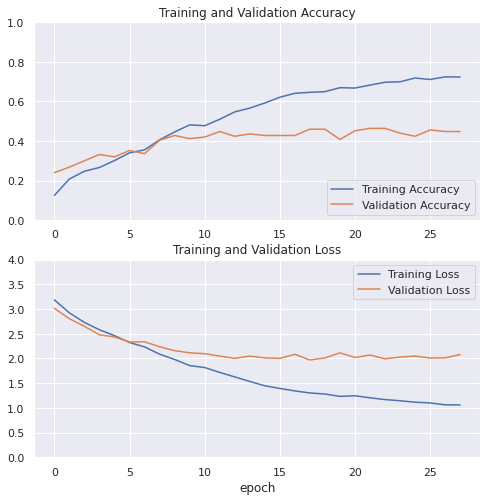

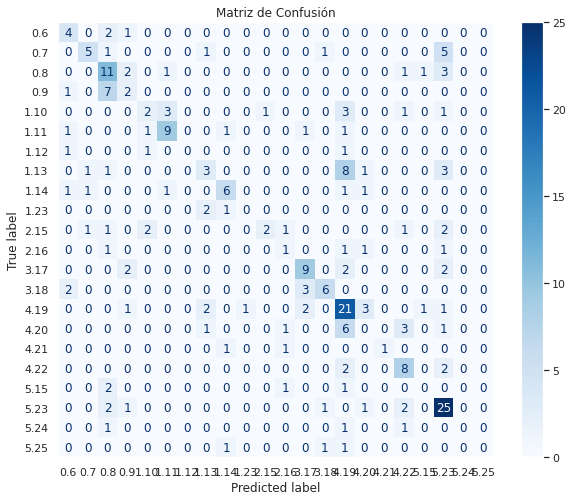

F1 Score:  0.3279521831125867


In [ ]:
X_train_aumentado, y_aumentado =gaussiano_p(X_train,y_train_list)
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train_aumentado, pd.get_dummies(y_aumentado), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Brillo

In [ ]:
imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.2,0.3]) #[1.5,1.8]
imageDataGenerator_obj_1 = ImageDataGenerator(brightness_range=[0.15,0.25]) #[1.5,1.8]

In [ ]:
def brillo_p(X,y):
  c=0
  for clases in df_2.combinacion.unique():
    idx_post=df_2[df['combinacion']==clases].index
    obs_post=len(idx_post)

    if 20<= obs_post < 30: #1 vez

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        iterator = imageDataGenerator_obj.flow(image, batch_size=1)
        chunk = iterator.next()
        sub_img = chunk[0].astype('uint8')
        augmented_image=tf.expand_dims(sub_img, 0)
        if c==0:
            c=1
            X_train_aumentado= augmented_image
            y=y+[clases]
        else: 
            X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image),axis=0)
            y=y+[clases]
        

    if obs_post < 20: #2 veces

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        if c==0:
          c=1
          iterator = imageDataGenerator_obj.flow(image, batch_size=1)
          chunk = iterator.next()
          sub_img = chunk[0].astype('uint8')
          augmented_image0=tf.expand_dims(sub_img, 0)
          X_train_aumentado= augmented_image0
          iterator = imageDataGenerator_obj_1.flow(image, batch_size=1)
          chunk = iterator.next()
          sub_img = chunk[0].astype('uint8')
          augmented_image1=tf.expand_dims(sub_img, 0)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]
        else: 
          iterator = imageDataGenerator_obj.flow(image, batch_size=1)
          chunk = iterator.next()
          sub_img = chunk[0].astype('uint8')
          augmented_image0=tf.expand_dims(sub_img, 0)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image0),axis=0)
          iterator = imageDataGenerator_obj_1.flow(image, batch_size=1)
          chunk = iterator.next()
          sub_img = chunk[0].astype('uint8')
          augmented_image1=tf.expand_dims(sub_img, 0)
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]

  return X_train_aumentado, y

dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


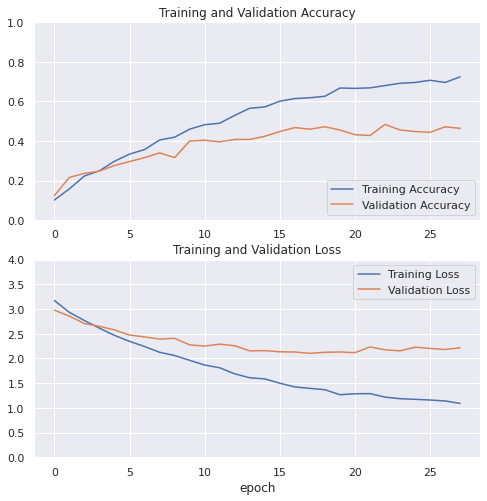

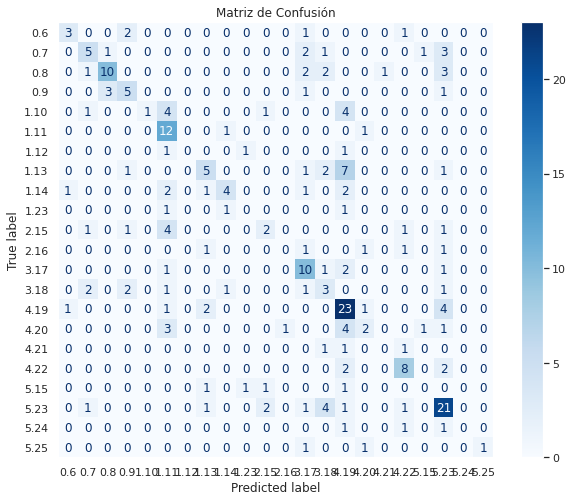

F1 Score:  0.31895871437650736


In [ ]:
X_train_aumentado, y_aumentado =brillo_p(X_train,y_train_list)
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train_aumentado, pd.get_dummies(y_aumentado), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Cropping(zoom)

In [ ]:
def zoom_p(X,y):
  c=0
  for clases in df_2.combinacion.unique():
    idx_post=df_2[df['combinacion']==clases].index
    obs_post=len(idx_post)

    if 20<= obs_post < 30: #1 vez

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        y = tf.keras.layers.Cropping2D(cropping=((10, 10), (10, 10)))(image) #(,)-vertical (,)- horizontal 
        augmented_image = cv2.resize(np.array(y)[0], (254, 254))
        if c==0:
            c=1
            X_train_aumentado= np.array(augmented_image)
            y=y+[clases]
        else: 
            X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image),axis=0)
            y=y+[clases]
        

    if obs_post < 20: #2 veces

      for idx in idx_post:
        image = tf.expand_dims(X[idx], 0)
        if c==0:
          c=1
          y = tf.keras.layers.Cropping2D(cropping=((10, 10), (10, 10)))(image) #(,)-vertical (,)- horizontal 
          augmented_image0 = cv2.resize(np.array(y)[0], (254, 254))
          X_train_aumentado= np.array(augmented_image0)

          y = tf.keras.layers.Cropping2D(cropping=((10, 10), (10, 10)))(image) #(,)-vertical (,)- horizontal 
          augmented_image1 = cv2.resize(np.array(y)[0], (254, 254))
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]
        else: 
          y = tf.keras.layers.Cropping2D(cropping=((10, 10), (10, 10)))(image) #(,)-vertical (,)- horizontal 
          augmented_image0 = cv2.resize(np.array(y)[0], (254, 254))
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image0),axis=0)
          y = tf.keras.layers.Cropping2D(cropping=((10, 10), (10, 10)))(image) #(,)-vertical (,)- horizontal 
          augmented_image1 = cv2.resize(np.array(y)[0], (254, 254))
          X_train_aumentado=np.concatenate((X_train_aumentado,augmented_image1),axis=0)
          y=y+[clases]+[clases]

  return X_train_aumentado, y

dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)


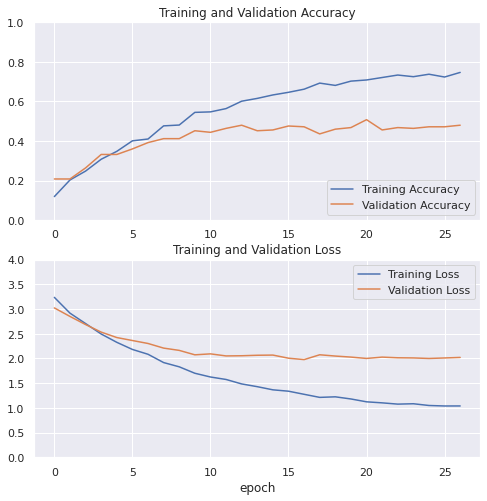

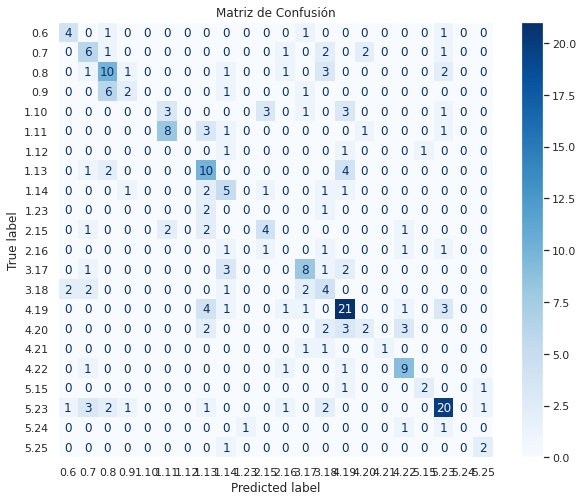

F1 Score:  0.371029326634487


In [ ]:
X_train_aumentado, y_aumentado =brillo_p(X_train,y_train_list)
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train_aumentado, pd.get_dummies(y_aumentado), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

## Comparacion


In [ ]:
sin_aumentation=[]
rotacioness=[]
Gaussianos=[]
Brillos=[]
Zoom=[]
X_train_rot, y_train_rot =rotaciones_p(X_train,y_train_list)
X_train_gauss, y_train_gauss =gaussiano_p(X_train,y_train_list)
X_train_brillo, y_train_brillo =brillo_p(X_train,y_train_list)
X_train_zoom, y_train_zoom =brillo_p(X_train,y_train_list)
for i in range(10):
  #Original
  features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning(X_val, X_train, y_train, 'a', 224, False, 32 , 22, "yoga", pd.get_dummies(y_val))
  sin_aumentation.append(f1_score(y_val, y_pred_clase, average='macro'))

  #Rotaciones
  features_1, epocas1, acc1, val_acc1, loss1, val_loss1, y_pred_clase1 = transferlearning(X_val, X_train_rot, pd.get_dummies(y_train_rot), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  rotacioness.append(f1_score(y_val, y_pred_clase1, average='macro'))

  #Ruido Gaussiano
  features_2, epocas2, acc2, val_acc2, loss2, val_loss2, y_pred_clase2 = transferlearning(X_val, X_train_gauss, pd.get_dummies(y_train_gauss), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  Gaussianos.append(f1_score(y_val, y_pred_clase2, average='macro'))

  #Brillo
  features_3, epocas3, acc3, val_acc3, loss3, val_loss3, y_pred_clase3 = transferlearning(X_val, X_train_brillo, pd.get_dummies(y_train_brillo), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  Brillos.append(f1_score(y_val, y_pred_clase3, average='macro'))

  #Zoom
  features_4, epocas4, acc4, val_acc4, loss4, val_loss4, y_pred_clase4= transferlearning(X_val, X_train_zoom, pd.get_dummies(y_train_zoom), features, 224, True, 32 , 22, "yoga", pd.get_dummies(y_val))
  Zoom.append(f1_score(y_val, y_pred_clase4, average='macro'))


dimensiones feautures Train (1000, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1000, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1202, 7, 7, 1920)
dimensiones feautures Test (250, 7, 7, 1920)
dimensiones feautures Train (1000, 7, 7, 1920)
dimensiones feautures Test (250, 

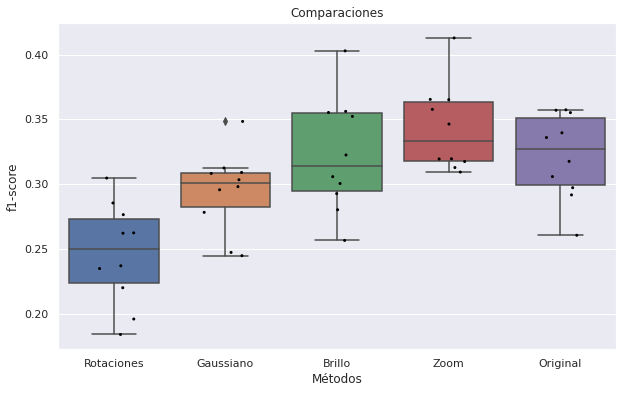

In [ ]:
#Plot

a = pd.DataFrame({ 'Métodos' : np.repeat('Rotaciones',10), 'f1-score': rotacioness })
b = pd.DataFrame({ 'Métodos' : np.repeat('Gaussiano',10), 'f1-score': Gaussianos })
c = pd.DataFrame({ 'Métodos' : np.repeat('Brillo',10), 'f1-score': Brillos })
d = pd.DataFrame({ 'Métodos' : np.repeat('Zoom',10), 'f1-score': Zoom })
e = pd.DataFrame({ 'Métodos' : np.repeat('Original',10), 'f1-score':sin_aumentation })
df=a.append(b).append(c).append(d).append(e)

plt.figure(figsize=(10,6))
ax = sns.boxplot(x='Métodos', y='f1-score', data=df)
# add stripplot
ax = sns.stripplot(x='Métodos', y='f1-score', data=df, color="black", jitter=0.2, size=3)

# add title
plt.title('Comparaciones', loc="center")

# show the graph
plt.show()

En este caso, se valida que zoom es uno de los mejores métodos para el problema de clasificación de poses de Yoga. Esto se atribuye principalmente a la naturaleza del dataset, donde las imagenes generalmente contenian mucho borde con fondo sin patrones relevantes. Por lo que al quitarlos el modelo logra enfocarse de mejor manera en patrones locales relevantes. Por otro lado, Rotaciones nuevamente resulta ser un método perjudicial para este problema, dada la naturaleza de este. Finalmente, se valida que Ruido Gaussiano es un método que disminuye la viariabilidad de modelo, haciendo que este sea más robusto.

# Data sintética

Para este experimento, dado que en los casos anteriores, data augmentation daba indicios de que podría llegar a empeorar los resultados, utilizaremos un caso de desbalanceo extremo para probar si la aumentación excesiva de datos confunde el aprendizaje del modelo. Donde la intuición consiste en que si repetimos muchas veces un subconjunto pequeño de ejemplos, los patrones que aprende la red no deberían ser generalizables a un conjunto de pruebas arbitrario.

## Sin Data Augmentation

In [ ]:
img_cat = path+'catvsdog/cat'
img_dog = path+'catvsdog/dog'

In [ ]:
df = pd.DataFrame(columns = ['image', 'class'])

for i in range(50):
  if i<200:
    df.loc[i] = ['cat.'+str(i)+'.jpg', 'cat']

c = len(df)

for i in range(1200):
    df.loc[c] = ['dog.'+str(i)+'.jpg', 'dog']
    c+=1

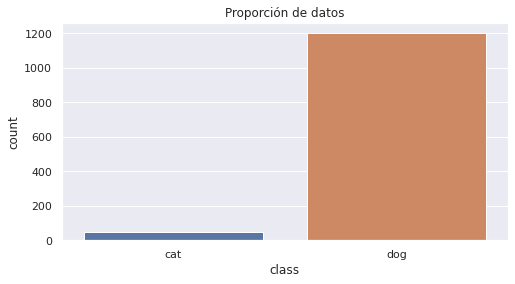

In [ ]:
plt.figure(figsize=(8,4))

plt.title('Proporción de datos')
sns.countplot(x="class", data=df)

plt.show()

In [ ]:
df_test = pd.DataFrame(columns=['image', 'class'])


for i in range(50,200):
  df_test.loc[i-50] = ['cat.'+str(i)+'.jpg', 'cat']

df_test

image class
0     cat.50.jpg   cat
1     cat.51.jpg   cat
2     cat.52.jpg   cat
3     cat.53.jpg   cat
4     cat.54.jpg   cat
..           ...   ...
145  cat.195.jpg   cat
146  cat.196.jpg   cat
147  cat.197.jpg   cat
148  cat.198.jpg   cat
149  cat.199.jpg   cat

[150 rows x 2 columns]

In [ ]:
def process_dataset(img_folder, datos, clase ,width=254, height=254):
    data = []
    ids = []

    dat = datos[datos['class']==clase].reset_index(drop=True)
   
    for i in range(dat.shape[0]):
        filename = dat.image[i]
        image_path = os.path.join(img_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # ahora trabajamos con imágenes RGB

        # hacemos un resize del tamaño de las imágenes antes de ingresarlo a nuestro modelo
        image = cv2.resize(image, (width, height)) # por ejemplo, 52 x 52 x 3 (3 canales => rojo, verde y azul)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 # escalar a [0, 1] 


        # obtener la clase correspondiente en los datos del csv usando la id de la imagen
        c = dat.loc[dat['image'] == filename]['class'].values[0]
                 
        data.append([c, image])

        ids.append(filename)
    
    return np.array(data), np.array(ids)

In [ ]:
# img_data -> class, image
img_data_cat,  ids_cat = process_dataset(img_cat, df,'cat')
img_data_dog,  ids_dog = process_dataset(img_dog, df,'dog')

print(img_data_cat[0][1].shape)
print(img_data_dog[0][1].shape)
    


(254, 254, 3)
(254, 254, 3)


In [ ]:
img_data_cat_test,  ids_cat_test = process_dataset(img_cat, df_test,'cat')

In [ ]:
img_data = np.array(list(img_data_cat)+list(img_data_dog)) 
ids = np.array(list(ids_cat)+list(ids_dog))

In [ ]:
n_classes = 2

X = np.array(img_data[:, 1].tolist())

# codificación one-hot para etiquetas (cat - dog)
Y =  pd.get_dummies(img_data[:, 0])

Y

cat  dog
0       1    0
1       1    0
2       1    0
3       1    0
4       1    0
...   ...  ...
1245    0    1
1246    0    1
1247    0    1
1248    0    1
1249    0    1

[1250 rows x 2 columns]

In [ ]:
X_test = np.array(img_data_cat_test[:, 1].tolist())

# codificación one-hot para etiquetas (cat - dog)
Y_test =  pd.get_dummies(img_data_cat_test[:, 0])

Y_test

cat
0      1
1      1
2      1
3      1
4      1
..   ...
145    1
146    1
147    1
148    1
149    1

[150 rows x 1 columns]

In [ ]:
# Split de los ejemplos de entrenamiento
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)


print("X,y Shapes:", X.shape, Y.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)


X_val = np.concatenate((X_val, X_test), axis=0)

y_val=y_val.idxmax(axis=1)

y_val = list(y_val) + list(Y_test.idxmax(axis=1))

df_2 = df.iloc[y_train.index].reset_index()

X,y Shapes: (1250, 254, 254, 3) (1250, 2)
X,y Train Shapes: (1000, 254, 254, 3) (1000, 2)
X,y Val Shapes: (250, 254, 254, 3) (250, 2)


In [ ]:
def transferlearning_sintetic(X_test, X_train_aumentado, Y_train, features, tam_img, aumentado, _batch_size, n_cat, Y_test): #Agregar variable problema PENDIENTE

  base_model  = tf.keras.applications.DenseNet201(input_shape=(tam_img,tam_img,3),
                                                include_top=False,
                                                weights='imagenet') # cargamos con pesos entrenados en ImageNet
  base_model.trainable = False
  model3 = keras.Model(inputs=base_model.inputs, outputs = base_model.layers[-1].output)
  #extraccion de caracteristicas
  features_aumentado = model3.predict(X_train_aumentado)
  features_test = model3.predict(X_test)


  if aumentado == True:
    features_aumentado= np.concatenate((features, features_aumentado),axis=0)

  print("dimensiones feautures Train",features_aumentado.shape)
  print("dimensiones feautures Test",features_test.shape)

  modelFF_2 = modelo_denso(features_aumentado, n_cat)

  modelFF_2.compile( loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])
  my_callbacks = [History(), EarlyStopping(patience=10, monitor="val_loss",restore_best_weights=True)]

  # Entrenar modelo
  history = modelFF_2.fit(
          x = features_aumentado,
          y = Y_train,
          validation_data=(features_test,Y_test),
          batch_size=_batch_size,
          epochs=100,
          verbose=0,
          callbacks= my_callbacks
      )

  epocas= len(history.history['accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']


  #Predicciones 

  y_pred = modelFF_2.predict(features_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred_clase=[] #Codificación

  for i in range(y_pred.shape[0]):
      respuesta= Y_train.columns[y_pred[i]]
      y_pred_clase.append(respuesta)


  
  return features_aumentado, epocas, acc, val_acc, loss, val_loss, y_pred_clase

**Train** 0.8 gatos (50) + 0.8 perros (1200)

**Test** 0.2 gatos (50) + 150 gatos + 0.2 perros (1200)

dimensiones feautures Train (1000, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)


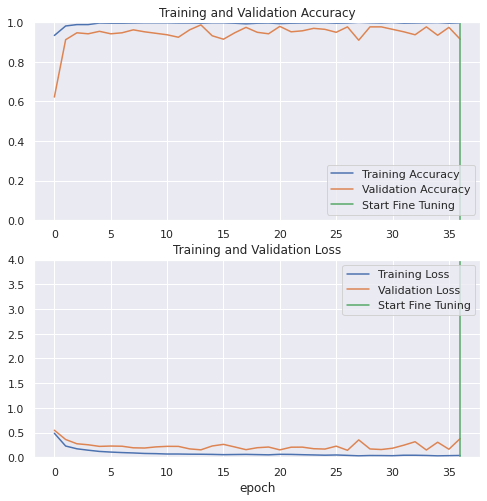

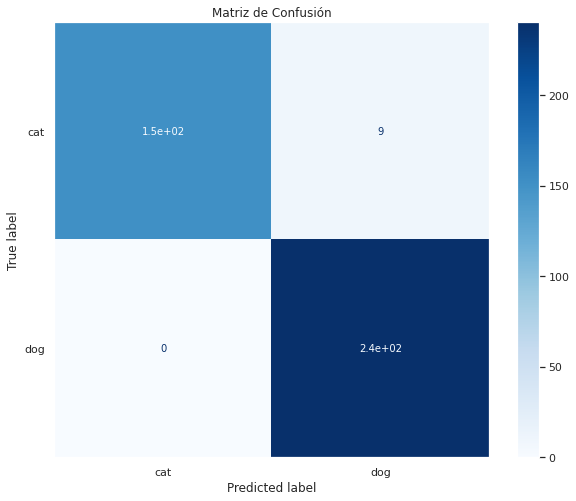

F1 Score:  0.9763280926360641


In [ ]:
features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning_sintetic(X_val, X_train, y_train, 'a', 254, False, 64, 2,pd.get_dummies(y_val))

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epocas-1,epocas-1],
            plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.plot([epocas-1,epocas-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

## Con Data Augmentation

In [ ]:
max = df_2['class'].value_counts().max()

dic = {}

for i in range(len(df_2['class'].value_counts().index)):

  division = max//df_2['class'].value_counts()[i]
  resto = int(max%df_2['class'].value_counts()[i])
  if division-1 <0:
    division=1
  
  dic[df_2['class'].value_counts().index[i]] = (int(division-1), resto )

In [ ]:
y_train_aumentado = list(y_train.idxmax(axis=1))

n_rot, _ = dic['cat']
im=len(df_2[df_2['class']=='cat'].index)

for i in range(n_rot*im):
    y_train_aumentado=y_train_aumentado+['cat']

y_train_aumentado =  pd.get_dummies(y_train_aumentado)

Agregamos al train 0.2 gatos (50) -> Amplificamos 22 veces cada foto de gatos

Train paso de 1000 -> 1920

Test quedo igual

### Rotaciones

In [ ]:
def rotaciones_sintetic(X_train):

  n_rot, _ = dic['cat']
  im = df_2[df_2['class']=='cat'].index
  #Rotaciones Solas
  imagen= X_train[im[0]]

  X_train_aumentado = n_rotaciones(imagen,n_rot)

  for i in im[1:]:
      imagen= X_train[i]
      X_train_aumentado=np.concatenate((X_train_aumentado, n_rotaciones(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train_2 = rotaciones_sintetic(X_train)

dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)


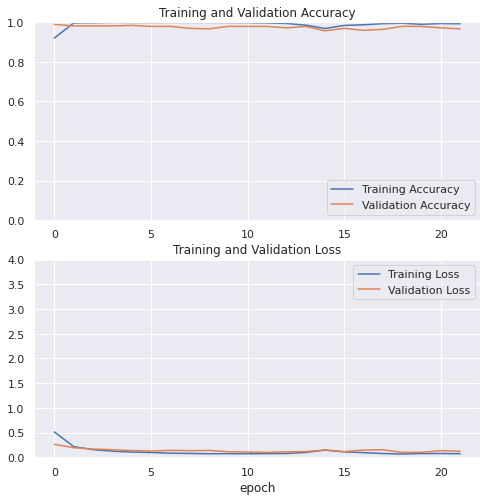

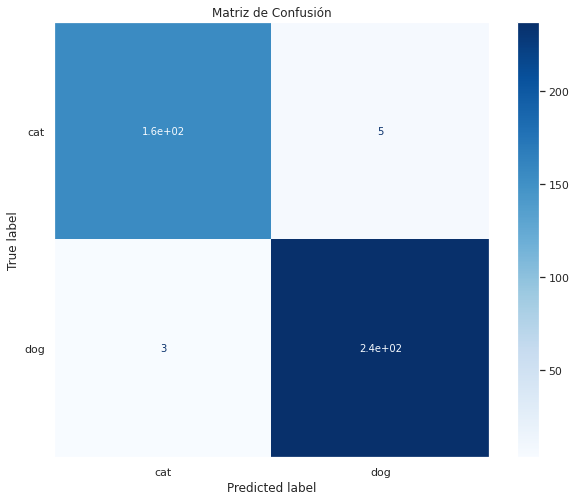

F1 Score:  0.9791226284610768


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning_sintetic(X_val, X_train_2, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Ruido Gaussiano

In [ ]:
def gaussiano_sintetic(X_train):

  n_rot, _ = dic['cat']
  im = df_2[df_2['class']=='cat'].index

  imagen = X_train[im[0]]

  X_train_aumentado = n_gaussiano(imagen,n_rot)
  #Rotaciones Solas
  
  for i in im[1:]:
      imagen= X_train[i]
      X_train_aumentado=np.concatenate((X_train_aumentado, n_gaussiano(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train_2 = gaussiano_sintetic(X_train)

dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)


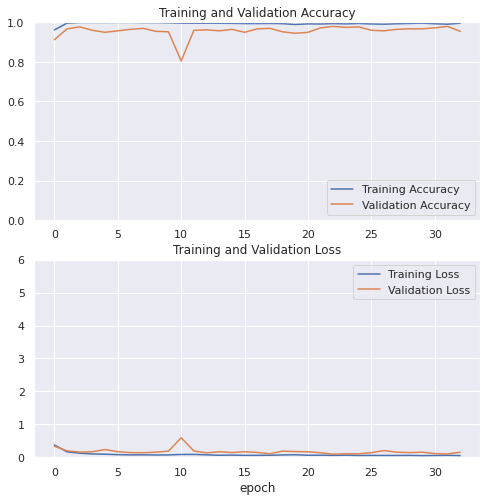

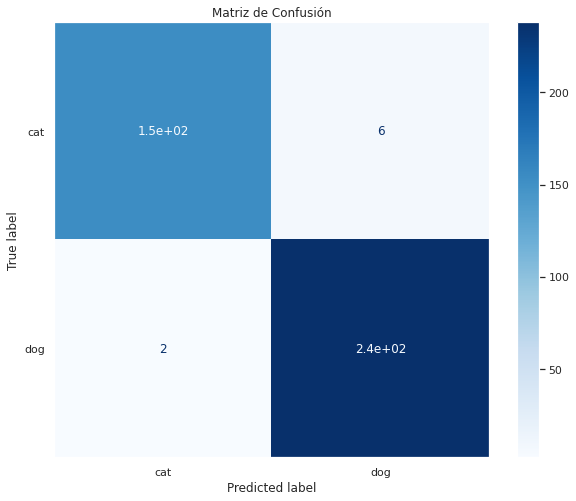

F1 Score:  0.9790773093419814


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning_sintetic(X_val, X_train_2, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Brillo

In [ ]:
def brillo_sintetic(X_train):

  n_rot, _ = dic['cat']
  im = df_2[df_2['class']=='cat'].index

  imagen = X_train[im[0]]

  X_train_aumentado = n_brillo(imagen,n_rot)
  #Rotaciones Solas
  
  for i in im[1:]:
      imagen= X_train[i]
      X_train_aumentado=np.concatenate((X_train_aumentado, n_brillo(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train_2 = brillo_sintetic(X_train)

dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)


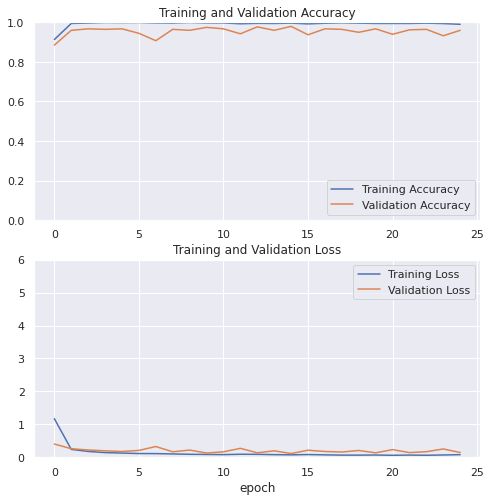

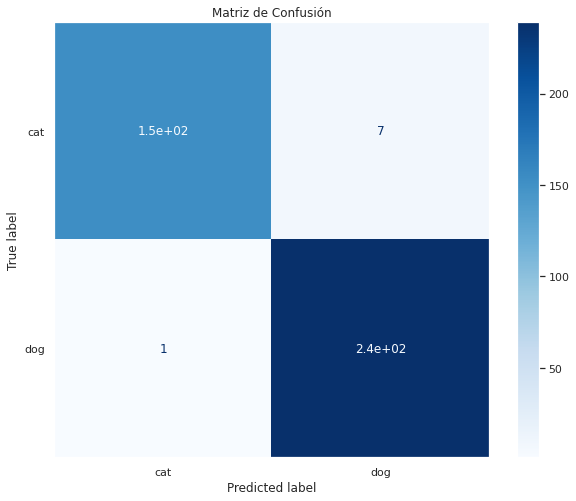

F1 Score:  0.9790306938219182


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning_sintetic(X_val, X_train_2, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

### Cropping (zoom)

In [ ]:
def n_zoom_sintetic(imagen, n_rot):
  
  imagen=tf.expand_dims(imagen, 0)
  n=2
  if n_rot == 1:
    n = 1

  for i in range(n_rot):
    n_v=29+n
    y = tf.keras.layers.Cropping2D(cropping=((n_v, n_v), (n_v, n_v)))(imagen) #(,)-vertical (,)- horizontal  
    y = cv2.resize(np.array(y)[0], (254, 254))
    sub_img=tf.expand_dims(y, 0)

    if i==0:
      n+=1
      arr=np.array(sub_img)
    else:
      n+=1
      arr=np.concatenate((arr, sub_img),axis=0)

  return arr

In [ ]:
def zoom_sintetic(X_train):

  n_rot, _ = dic['cat']
  im = df_2[df_2['class']=='cat'].index

  imagen = X_train[im[0]]

  X_train_aumentado = n_zoom_sintetic(imagen,n_rot)
  #Rotaciones Solas
  
  for i in im[1:]:
      imagen= X_train[i]
      X_train_aumentado=np.concatenate((X_train_aumentado, n_zoom_sintetic(imagen, n_rot)),axis=0)

  return X_train_aumentado

In [ ]:
X_train_2 = zoom_sintetic(X_train)

dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)


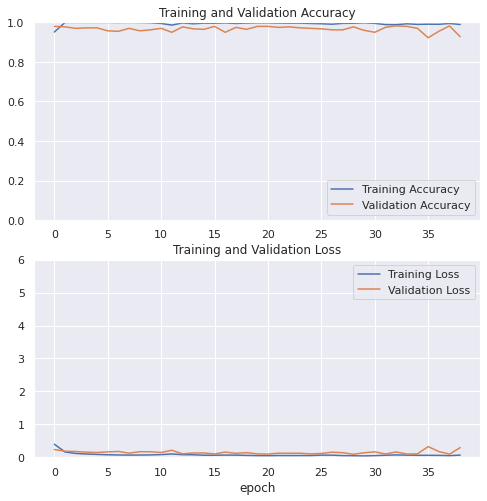

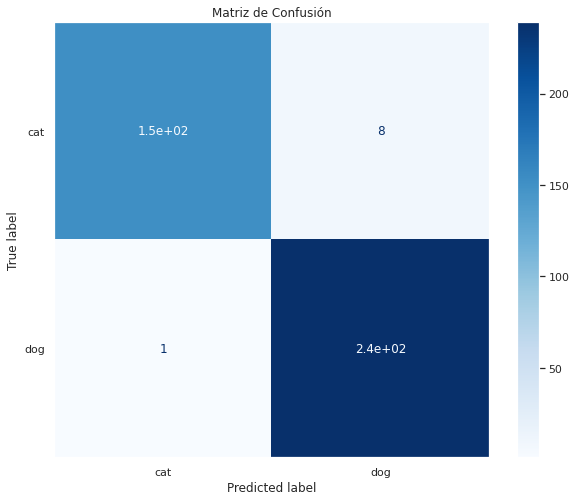

F1 Score:  0.9763827567883174


In [ ]:
features_, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning_sintetic(X_val, X_train_2, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val) )

#Graficas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Matriz de confusión
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_clase, labels=y_train.columns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.columns)
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

print("F1 Score: ", f1_score(y_val, y_pred_clase, average='macro'))

resultados = [(f1_score(y_val, y_pred_clase, average='macro'), "Original")]

## Comparacion


No es posible ejecutar la celda por problemas de memoria RAM disponible.

In [ ]:
sin_aumentation=[]
rotacioness=[]
Gaussianos=[]
Brillos=[]
Zoom=[]
X_train_rot=rotaciones_sintetic(X_train)
X_train_gauss=gaussiano_sintetic(X_train)
X_train_brillo=brillo_sintetic(X_train)
X_train_zoom=zoom_sintetic(X_train)
for i in range(10):
  #Original
  features, epocas, acc, val_acc, loss, val_loss, y_pred_clase = transferlearning_sintetic(X_val, X_train, y_train, 'a', 254, False, 64, 2,pd.get_dummies(y_val))
  sin_aumentation.append(f1_score(y_val, y_pred_clase, average='macro'))

  #Rotaciones
  features_1, epocas1, acc1, val_acc1, loss1, val_loss1, y_pred_clase1 = transferlearning_sintetic(X_val, X_train_rot, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val))
  rotacioness.append(f1_score(y_val, y_pred_clase1, average='macro'))

  #Ruido Gaussiano
  features_2, epocas2, acc2, val_acc2, loss2, val_loss2, y_pred_clase2 = transferlearning_sintetic(X_val, X_train_gauss, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val))
  Gaussianos.append(f1_score(y_val, y_pred_clase2, average='macro'))

  #Brillo
  features_3, epocas3, acc3, val_acc3, loss3, val_loss3, y_pred_clase3 = transferlearning_sintetic(X_val, X_train_brillo, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val))
  Brillos.append(f1_score(y_val, y_pred_clase3, average='macro'))

  #Zoom
  features_4, epocas4, acc4, val_acc4, loss4, val_loss4, y_pred_clase4= transferlearning_sintetic(X_val, X_train_zoom, y_train_aumentado, features, 254, True, 64 , 2, pd.get_dummies(y_val))
  Zoom.append(f1_score(y_val, y_pred_clase4, average='macro'))


dimensiones feautures Train (1000, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)
dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)
dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)
dimensiones feautures Train (1920, 8, 8, 1920)
dimensiones feautures Test (400, 8, 8, 1920)


In [ ]:
#Plot

a = pd.DataFrame({ 'Métodos' : np.repeat('Rotaciones',10), 'f1-score': rotacioness })
b = pd.DataFrame({ 'Métodos' : np.repeat('Gaussiano',10), 'f1-score': Gaussianos })
c = pd.DataFrame({ 'Métodos' : np.repeat('Brillo',10), 'f1-score': Brillos })
d = pd.DataFrame({ 'Métodos' : np.repeat('Zoom',10), 'f1-score': Zoom })
e = pd.DataFrame({ 'Métodos' : np.repeat('Original',10), 'f1-score':sin_aumentation })
df=a.append(b).append(c).append(d).append(e)

plt.figure(figsize=(10,6))
ax = sns.boxplot(x='Métodos', y='f1-score', data=df)
# add stripplot
ax = sns.stripplot(x='Métodos', y='f1-score', data=df, color="black", jitter=0.2, size=3)

# add title
plt.title('Comparaciones', loc="center")

# show the graph
plt.show()

Contrario a lo que se pensaba, a pesar de tener un problema extremadamente desbalanceado, data augmentation no empeora en ningún caso el F1-score del modelo, sin embargo, tampoco ofrece mejoras notables, más aún, están cerca de ser imperceptibles para este problema, el cual manifiesta ser demasiado sencillo de clasificar para la red.

# Conclusión

Expuestos los experimentos realizados, se concluye que la hipótesis de trabajo es falsa, pues en ninguno de los experimentos se apreciaron **mejoras notables** en los resultados de la métrica de interés. 

Además las técnicas de aumentación de datos, dependen de la naturaleza del problema, por ejemplos para el problema de reconocimiento de poses de Yoga, rotar imagenes es un método que empeora los resultados de clasificación.

Por otro lado, métodos como Ruido Gaussiano puede brindar otros beneficios como dar robustes al modelo, en vez de mejorar la capacidad de generalización del modelo.

